In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import PIL
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
import lime
import cv2

from skimage.segmentation import mark_boundaries
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.metrics import ConfusionMatrixDisplay, classification_report,precision_score,recall_score
import seaborn as sns

In [2]:
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
# Create a folder to save the images if it doesn't exist
save_folder = 'new_model2_images_with_cnn'
os.makedirs(save_folder, exist_ok=True)

# Deep Learning Model

In [4]:
# Adding data augmentation for the image preprocessing
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [5]:
# Load the dataset from the directory path
datadir = '/Users/opeoluwa/Downloads/dissertation_project/new_BHI_dataset/'

data_dir = pathlib.Path(datadir)

# Creating a list for the class categories
categories = ['benign', 'malignant']


image_count = len(list(data_dir.glob('*/*.png')))

# Define the batch size for the model network
batch_size = 32

# Defining the image size for resizing (width & height)
img_height = 224
img_width = 224

In [10]:
print(image_count)

12704


In [64]:
# Accessing the total no of benign images in the folder
image_benign = len(list(data_dir.glob('benign/*.png')))

In [65]:
print(image_benign)

10276


In [69]:
for a in list(data_dir.glob('benign/*.png')):
    print(a)
    print(type(a))
#     b = cv2.imread(a)
#     print(a)
    break

/Users/opeoluwa/Downloads/dissertation_project/new_BHI_dataset/benign/8867_idx5_x2501_y1301_class0.png
<class 'pathlib.PosixPath'>


In [71]:
import glob

In [72]:
x_image = [cv2.imread(a, cv2.IMREAD_COLOR) for a in glob.glob(f'{datadir}benign/*.png')]

In [73]:
print(len(x_image))

10276


In [8]:
# Accessing the total no of malignant images in the folder
image_malignant = len(list(data_dir.glob('malignant/*.png')))

In [9]:
print(image_malignant)

2428


In [76]:
x_image_malignant = [cv2.imread(a, cv2.IMREAD_COLOR) for a in glob.glob(f'{datadir}malignant/*.png')]

In [77]:
print(len(x_image_malignant))

2428


In [11]:
benign_label =np.zeros(image_benign)
print(benign_label)

[0. 0. 0. ... 0. 0. 0.]


In [12]:
malignant_label =np.ones(image_malignant)
print(malignant_label)

[1. 1. 1. ... 1. 1. 1.]


In [13]:
class_label = np.concatenate([benign_label, malignant_label])
print(class_label)
print(class_label.shape)

[0. 0. 0. ... 1. 1. 1.]
(12704,)


In [14]:
from tensorflow.keras.utils import to_categorical

In [15]:
new_class_label = to_categorical(class_label, num_classes =2)

In [16]:
print(new_class_label)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [19]:
# Splitting the dataset into train and validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 12704 files belonging to 2 classes.
Using 10164 files for training.


In [20]:
for i in train_ds:
    print((i))
    break

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[231.      , 218.      , 231.      ],
         [231.      , 218.      , 231.      ],
         [230.53572 , 217.0134  , 230.30357 ],
         ...,
         [215.66516 , 178.8259  , 206.59375 ],
         [217.      , 179.      , 207.      ],
         [217.      , 179.      , 207.      ]],

        [[231.      , 218.      , 231.      ],
         [231.      , 218.      , 231.      ],
         [230.53572 , 217.0134  , 230.30357 ],
         ...,
         [215.66516 , 178.8259  , 206.59375 ],
         [217.      , 179.      , 207.      ],
         [217.      , 179.      , 207.      ]],

        [[230.47768 , 216.83928 , 230.07143 ],
         [230.47768 , 216.83928 , 230.07143 ],
         [229.94267 , 215.70111 , 229.27396 ],
         ...,
         [213.68288 , 174.85875 , 203.43314 ],
         [214.85268 , 174.7634  , 203.63393 ],
         [214.85268 , 174.7634  , 203.63393 ]],

        ...,

        [[228.4643  , 218.69644 

In [21]:
# Splitting the dataset into train and validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 12704 files belonging to 2 classes.
Using 2540 files for validation.


In [22]:
# Create the testing subset manually from the train dataset
test_ds = train_ds.take(int(0.10 * image_count / batch_size))

In [23]:
len(list(test_ds))

39

In [24]:
len(list(val_ds))

80

In [25]:
len(list(train_ds))

318

# Exploratory data analysis (EDA)

In [26]:
# Configuring the class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)

In [27]:
# Displaying the class distribution
print("Class distribution:")
for class_name in class_names:
    count = len(list((data_dir / class_name).glob('*.png')))
    print(f"{class_name}: {count} samples")

Class distribution:
benign: 10276 samples
malignant: 2428 samples


Image dimension statistics:
Mean Height: 224.0
Mean Width: 224.0


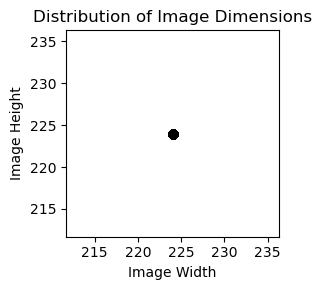

In [28]:
# Verifying the image dimensions
image_dimensions = []
for images, _ in train_ds:
    for img in images:
        image_dimensions.append(img.shape[:2])

# Creating an instance of the image dimensions array
image_dimensions = np.array(image_dimensions)
print("Image dimension statistics:")
print("Mean Height:", np.mean(image_dimensions[:, 0]))
print("Mean Width:", np.mean(image_dimensions[:, 1]))

# Visualize distribution of image dimensions
plt.figure(figsize=(3, 3))
plt.scatter(image_dimensions[:, 1], image_dimensions[:, 0], color='black', alpha=0.3)
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Distribution of Image Dimensions")
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Distribution_of_Image_Dimension.png'))
plt.show()

In [29]:
# Calculate class distribution for each datasets
complete_class_counts = [len(list((data_dir / class_name).glob('*.png'))) for class_name in class_names]
train_class_counts = [int(complete_class_counts[0]*0.7), int(complete_class_counts[1]*0.7)]
val_class_counts = [int(complete_class_counts[0]*0.2), int(complete_class_counts[1]*0.2)]
test_class_counts = [int(complete_class_counts[0]*0.1), int(complete_class_counts[1]*0.1)]

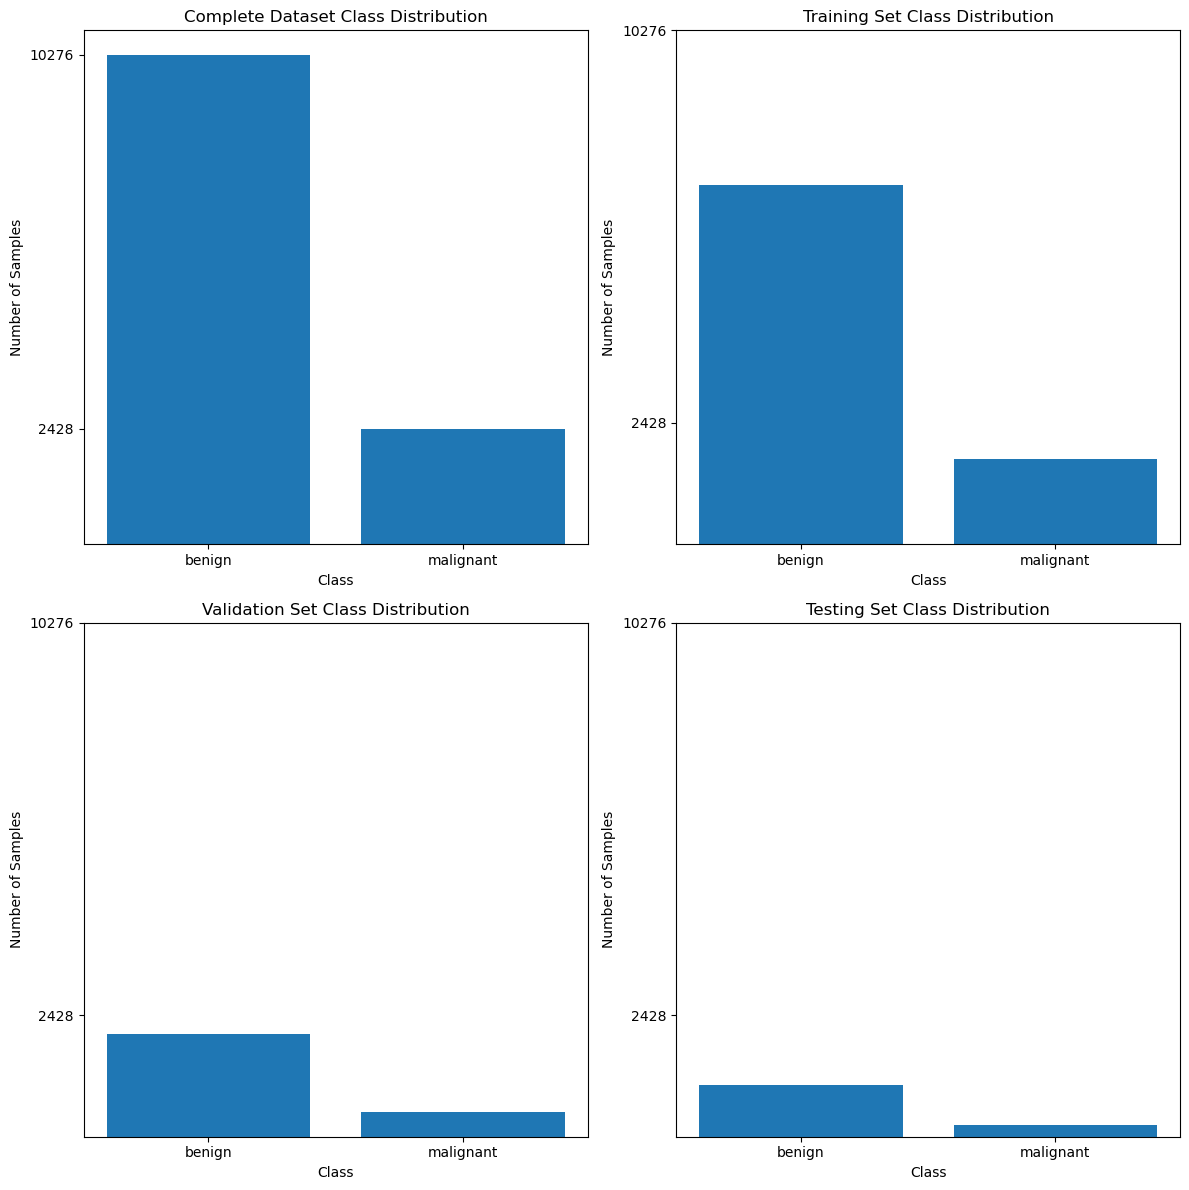

In [30]:
# Create separate subplots for class distribution for every split dataset
plt.figure(figsize=(12, 12))

# Plot class distribution for the complete dataset
plt.subplot(2, 2, 1)
plt.bar(class_names, complete_class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Complete Dataset Class Distribution")
plt.yticks(complete_class_counts)

# Plot class distribution for the training dataset
plt.subplot(2, 2, 2)
plt.bar(class_names, train_class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Training Set Class Distribution")
plt.yticks(complete_class_counts)

# Plot class distribution for the validation dataset
plt.subplot(2, 2, 3)
plt.bar(class_names, val_class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Validation Set Class Distribution")
plt.yticks(complete_class_counts)

# Plot class distribution for the testing dataset
plt.subplot(2, 2, 4)
plt.bar(class_names, test_class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Testing Set Class Distribution")
plt.yticks(complete_class_counts)

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Class_Distribution.png'))
plt.show()


# Before Rescaling

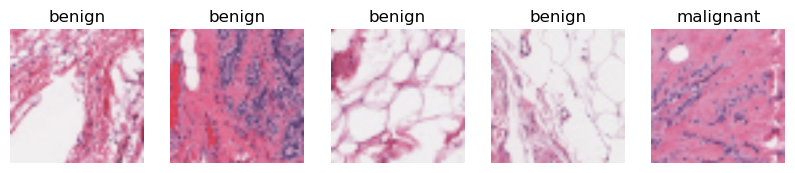

In [31]:
# Display sample images
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(5):
        plt.subplot(1, 5, i+1)

        # Display with proper data type and range
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [32]:
# Verify data loading and pixel values before and after rescaling
for images, labels in train_ds.take(1):
    print(f"Number of images: {len(images)}")
    print(f"Labels: {labels}")

    # Before rescaling
    print("Before rescaling:")
    print(images[0][0][:3])  # Print first few pixel values

Number of images: 32
Labels: [0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1]
Before rescaling:
tf.Tensor(
[[239.      217.      228.     ]
 [239.      217.      228.     ]
 [238.88393 216.65178 227.53572]], shape=(3, 3), dtype=float32)


Mean pixel value across all images: 183.76459


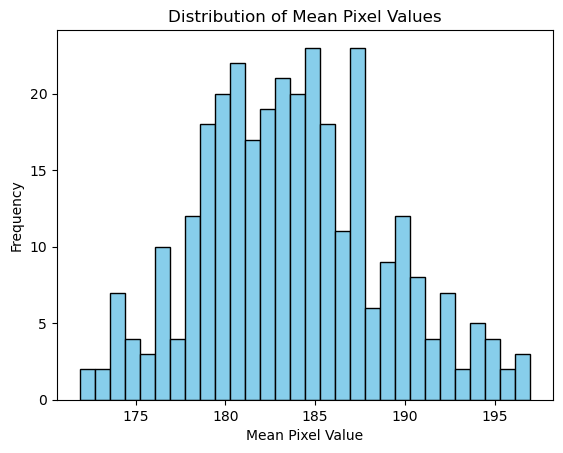

In [33]:
# Calculate image statistics
image_stats = []
for images, _ in train_ds:
    image_stats.append(np.mean(images.numpy()))
mean_pixel_value = np.mean(image_stats)

print("Mean pixel value across all images:", mean_pixel_value)

# Visualize pixel value distribution
plt.hist(image_stats, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Mean Pixel Value")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Pixel Values")
plt.savefig(os.path.join(save_folder, 'Distribution_of_Mean_Pixel_Values.png'))
plt.show()

Benign Mean pixel value across all images: 190.95297240800403


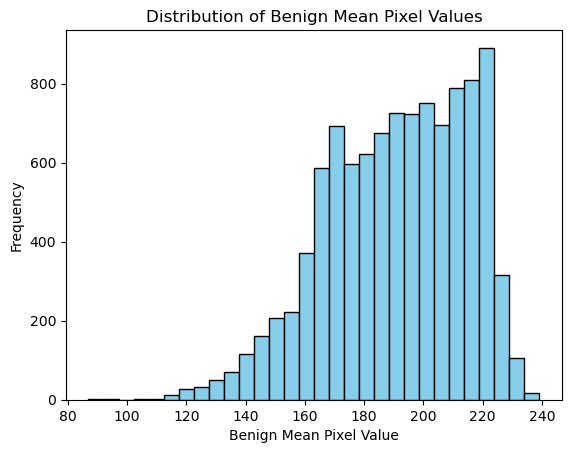

In [75]:
# Calculate benign image mean pixel value statistics
image_stats_benign = []
for images in x_image:
    image_stats_benign.append(np.mean(images))
mean_pixel_value_benign = np.mean(image_stats_benign)

print("Benign Mean pixel value across all images:", mean_pixel_value_benign)

# Visualize pixel value distribution
plt.hist(image_stats_benign, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Benign Mean Pixel Value")
plt.ylabel("Frequency")
plt.title("Distribution of Benign Mean Pixel Values")
plt.savefig(os.path.join(save_folder, 'Distribution_of_Benign_Mean_Pixel_Values.png'))
plt.show()

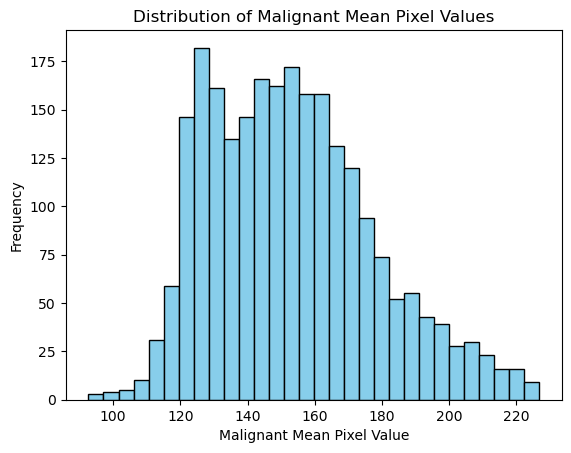

In [80]:
# Calculate the malignant image pixel value statistics
image_stats_malignant = []
for images in x_image_malignant:
    image_stats_malignant.append(np.mean(images))
mean_pixel_value_malignant = np.mean(image_stats_malignant)

# print("Malignant Mean pixel value across all images:", image_stats_malignant)

# Visualize pixel value distribution
plt.hist(image_stats_malignant, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Malignant Mean Pixel Value")
plt.ylabel("Frequency")
plt.title("Distribution of Malignant Mean Pixel Values")
plt.savefig(os.path.join(save_folder, 'Distribution_of_Malignant_Mean_Pixel_Values.png'))
plt.show()


## Rescaling the image datasets

In [34]:
# Rescale pixel values to [0, 1]
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [35]:
# Apply rescaling to all datasets
train_ds_rescaled = train_ds.map(lambda x, y: (rescale(x), y))
val_ds_rescaled = val_ds.map(lambda x, y: (rescale(x), y))
test_ds_rescaled = test_ds.map(lambda x, y: (rescale(x), y))

## After Rescaling

In [36]:
for images, labels in train_ds_rescaled.take(1):
    print(f"Number of images: {len(images)}")
    print(f"Labels: {labels}")

    # Before rescaling
    print("Before rescaling:")
    print(images[0][0][:3])  # Print first few pixel values

Number of images: 32
Labels: [0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
Before rescaling:
tf.Tensor(
[[0.93725497 0.9215687  0.9294118 ]
 [0.93725497 0.9215687  0.9294118 ]
 [0.93725497 0.9215687  0.92918426]], shape=(3, 3), dtype=float32)


Mean pixel value across all images: 0.7206265


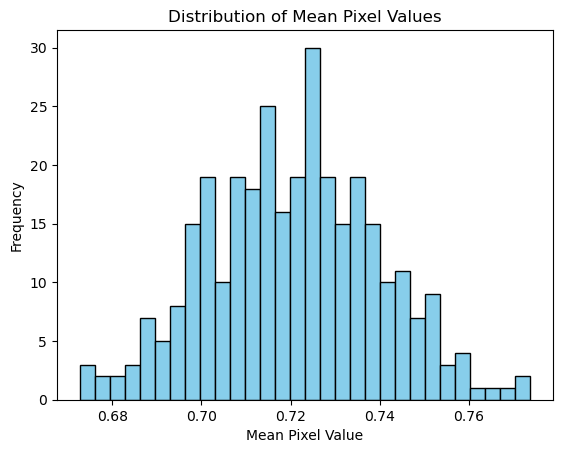

In [37]:
# Calculate image statistics
image_stats = []
for images, _ in train_ds_rescaled:
    image_stats.append(np.mean(images.numpy()))
mean_pixel_value = np.mean(image_stats)

print("Mean pixel value across all images:", mean_pixel_value)

# Visualize pixel value distribution
plt.hist(image_stats, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Mean Pixel Value")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Pixel Values")
plt.savefig(os.path.join(save_folder, 'Distribution_of_Mean_Pixel_Values(after rescaling).png'))
plt.show()

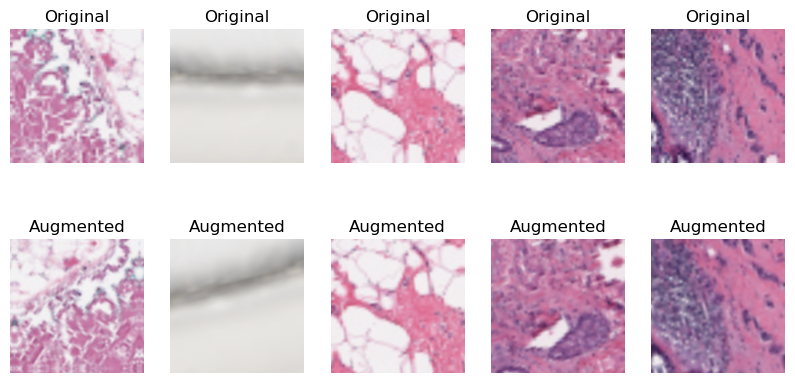

In [38]:
# Visualize original and augmented images
plt.figure(figsize=(10, 5))
for images, _ in train_ds_rescaled.take(1):
    for i in range(5):
        original_img = images[i].numpy().astype("float32")
        augmented_img = data_augmentation(images)[i].numpy().astype("float32")
        plt.subplot(2, 5, i+1)
        plt.imshow(original_img)
        plt.title("Original")
        plt.axis("off")
        plt.subplot(2, 5, i+6)
        plt.imshow(augmented_img)
        plt.title("Augmented")
        plt.axis("off")
plt.savefig(os.path.join(save_folder, 'Original_vs_Augmented_samples.png'))
plt.show()

# Base Model

Using:
1. X numbeer of epochs -100
2. Sparse categorical cross entropy --sigmoid

In [39]:
# Defining the base model from VGG16 model
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load pre-trained weights
    input_shape=(img_height, img_width, 3),
    include_top=False  # Exclude the top fully connected layers
)

In [40]:
# Add fine-tuning by unfreezing some layers
base_model.trainable = True
fine_tune_at = 15  # Freeze the first 15 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [41]:
# Create the feature extraction model with data augmentation
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)  # Adding dropout for regularization
outputs = keras.layers.Dense(num_classes, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                             

In [43]:
# Compile the model
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

AUTOTUNE = tf.data.AUTOTUNE

In [44]:
# Optimize data loading for training
train_ds = train_ds_rescaled.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_rescaled.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_rescaled.cache().prefetch(buffer_size=AUTOTUNE)  # Cache the testing dataset

In [45]:
# Implement learning rate scheduling
def lr_schedule(epoch):
    if epoch < 10:
        return 1e-4
    else:
        return 1e-5

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

In [46]:
# Implement early stopping based on validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with class weighting
class_weight = {0: 1.0, 1: 2.0}  # Class weight for addressing class imbalance

In [48]:
model.save("bc_modelTLsce.h5")

/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [173]:
epochs2 = 100
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs2,
    callbacks=[lr_callback, early_stopping],
    class_weight=class_weight
)

Epoch 1/100
318/318 [==============================] - 1875s 6s/step - loss: 0.2217 - accuracy: 0.9295 - val_loss: 0.2253 - val_accuracy: 0.9264 - lr: 1.0000e-04
Epoch 2/100
318/318 [==============================] - 2082s 7s/step - loss: 0.2074 - accuracy: 0.9333 - val_loss: 0.2318 - val_accuracy: 0.9244 - lr: 1.0000e-04
Epoch 3/100
318/318 [==============================] - 2097s 7s/step - loss: 0.2046 - accuracy: 0.9354 - val_loss: 0.2481 - val_accuracy: 0.9181 - lr: 1.0000e-04
Epoch 4/100
318/318 [==============================] - 2213s 7s/step - loss: 0.1933 - accuracy: 0.9380 - val_loss: 0.2336 - val_accuracy: 0.9134 - lr: 1.0000e-04
Epoch 5/100
318/318 [==============================] - 2319s 7s/step - loss: 0.1842 - accuracy: 0.9407 - val_loss: 0.2221 - val_accuracy: 0.9291 - lr: 1.0000e-04
Epoch 6/100
318/318 [==============================] - 2512s 8s/step - loss: 0.1873 - accuracy: 0.9388 - val_loss: 0.2101 - val_accuracy: 0.9213 - lr: 1.0000e-04
Epoch 7/100
318/318 [=======

In [174]:
model.save("bc_model2TLsce.h5")

/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluation

In [175]:
# Evaluate the model with the changed loss function on the training subset
train_loss2, train_accuracy2 = model.evaluate(train_ds)
print(f"Train Loss (Loss Change): {train_loss2}")
print(f"Train Accuracy (Loss Change): {train_accuracy2}")

318/318 [==============================] - 1223s 4s/step - loss: 0.1011 - accuracy: 0.9594
Train Loss (Loss Change): 0.1010696217417717
Train Accuracy (Loss Change): 0.9593663811683655


In [176]:
# Evaluate the model with the changed loss function on the validation subset
val_loss2, val_accuracy2 = model.evaluate(val_ds)
print(f"Val Loss (Loss Change): {val_loss2}")
print(f"Val Accuracy (Loss Change): {val_accuracy2}")

80/80 [==============================] - 341s 4s/step - loss: 0.2101 - accuracy: 0.9213
Val Loss (Loss Change): 0.21006904542446136
Val Accuracy (Loss Change): 0.9212598204612732


In [177]:
# Evaluate the model on the testing subset
test_loss2, test_accuracy2 = model.evaluate(test_ds)
print(f"Test Loss: {test_loss2}")
print(f"Test Accuracy: {test_accuracy2}")

39/39 [==============================] - 178s 5s/step - loss: 0.1072 - accuracy: 0.9623
Test Loss: 0.10724758356809616
Test Accuracy: 0.9623397588729858


In [178]:
# ROC Curve plotting function
def plot_roc_curve2(y_true2, y_score2):
    fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_score2)
    roc_auc2 = auc(fpr2, tpr2)

    plt.figure()
    plt.plot(fpr2, tpr2, color='darkorange', label=f'ROC curve (AUC = {roc_auc2:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    #plt.savefig(os.path.join(save_folder, f'ROC_Curve, epochs:{epochs}, loss_function: SparseCategoricalCrossEntropy.png'))
    plt.show()

In [179]:
# Confusion Matrix visualization function
def plot_confusion_matrix2(y_true2, y_pred2):
    cm2 = confusion_matrix(y_true2, y_pred2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm2, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(save_folder, f'Confusion_matrix, epochs:{epochs2}, loss_function: SparseCategoricalCrossEntropyTL2.png'))
    plt.show()

39/39 [==============================] - 183s 5s/step


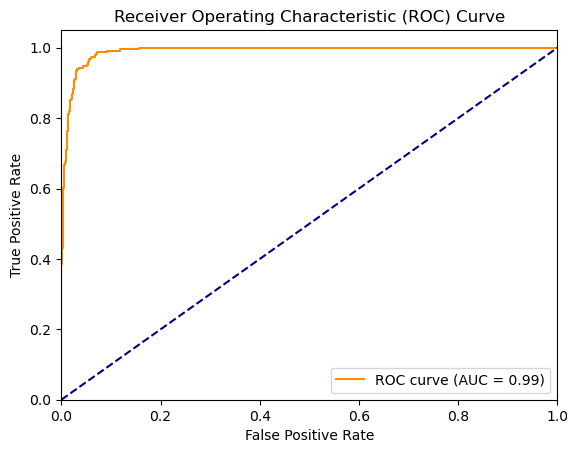

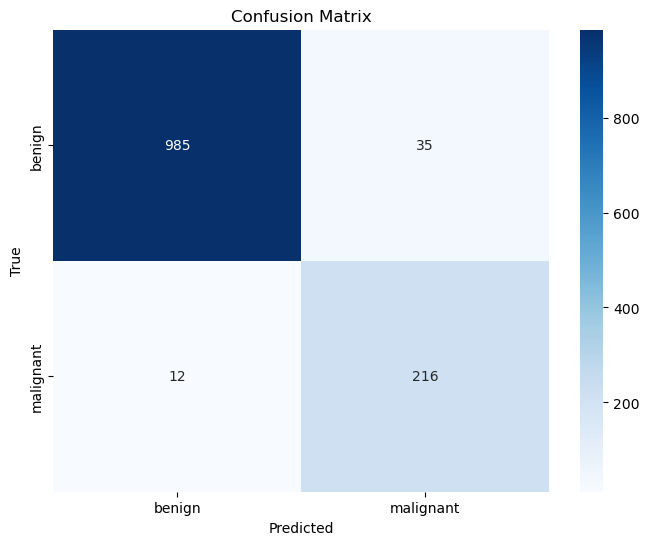

In [180]:
# Get the predicted probabilities and true labels
y_scores2 = model.predict(test_ds)
y_pred2 = np.argmax(y_scores2, axis=1)
y_true2 = np.concatenate([y2 for x2, y2 in test_ds], axis=0)

# Plot ROC curve
plot_roc_curve2(y_true2, y_scores2[:, 1])

# Plot Confusion Matrix
plot_confusion_matrix2(y_true2, y_pred2)

In [281]:
train_loss = train_loss2
train_accuracy = train_accuracy2
val_loss = val_loss2
val_accuracy = val_accuracy2
test_loss= test_loss2
test_accuracy = test_accuracy2 

In [283]:
y_true = y_true2
y_pred = y_pred2
y_scores = y_scores2

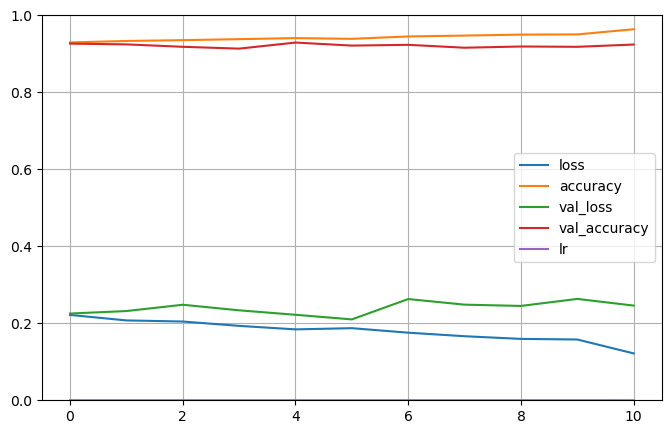

In [278]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [284]:
report = classification_report(y_true, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()
precision = precision_score(y_true, y_pred)
specificity = TN/(TN+FP)
sensitivity = recall_score(y_true, y_pred)


print(f'Sensitivity: {sensitivity}')
print(f'Precision: {precision}')
print(f'Specificity: {specificity}')

print('\n',report)

Sensitivity: 0.9473684210526315
Precision: 0.8605577689243028
Specificity: 0.9656862745098039

               precision    recall  f1-score   support

      benign       0.99      0.97      0.98      1020
   malignant       0.86      0.95      0.90       228

    accuracy                           0.96      1248
   macro avg       0.92      0.96      0.94      1248
weighted avg       0.96      0.96      0.96      1248



In [285]:
TP_indices = []
FP_indices = []
TN_indices = []
FN_indices = []

for i in range(len(y_true)):
    true_label = y_true[i]
    predicted_label = y_pred[i]
    
    if true_label == 1 and predicted_label == 1:  # True Positive
        TP_indices.append(i)
    elif true_label == 0 and predicted_label == 1:  # False Positive
        FP_indices.append(i)
    elif true_label == 0 and predicted_label == 0:  # True Negative
        TN_indices.append(i)
    elif true_label == 1 and predicted_label == 0:  # False Negative
        FN_indices.append(i)

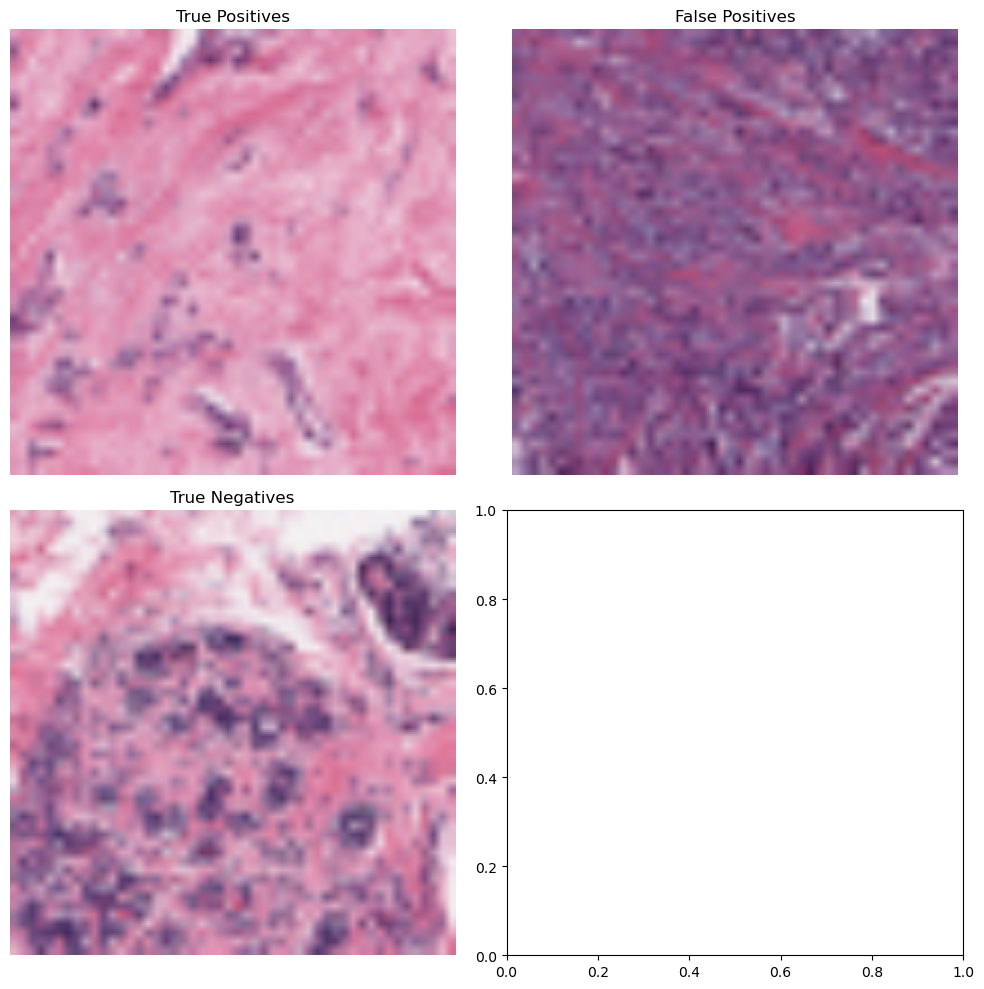

In [58]:
import matplotlib.pyplot as plt

# Define your TP_indices, FP_indices, TN_indices, FN_indices
# based on your classifier's predictions and true labels

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Loop through the test dataset to visualize images
for images, labels in test_ds.take(1):
    for i in range(images.shape[0]):
        # Check if the image is a TP, FP, TN, or FN based on indices
        if i in TP_indices:
            ax = axes[0, 0]
            title = "True Positives"
        elif i in FP_indices:
            ax = axes[0, 1]
            title = "False Positives"
        elif i in TN_indices:
            ax = axes[1, 0]
            title = "True Negatives"
        elif i in FN_indices:
            ax = axes[1, 1]
            title = "False Negatives"
        
        # Display the image in the corresponding subplot
        ax.imshow(images[i].numpy())
        ax.set_title(title)
        ax.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(save_folder, f"{title}_{i}.png"))
plt.show()

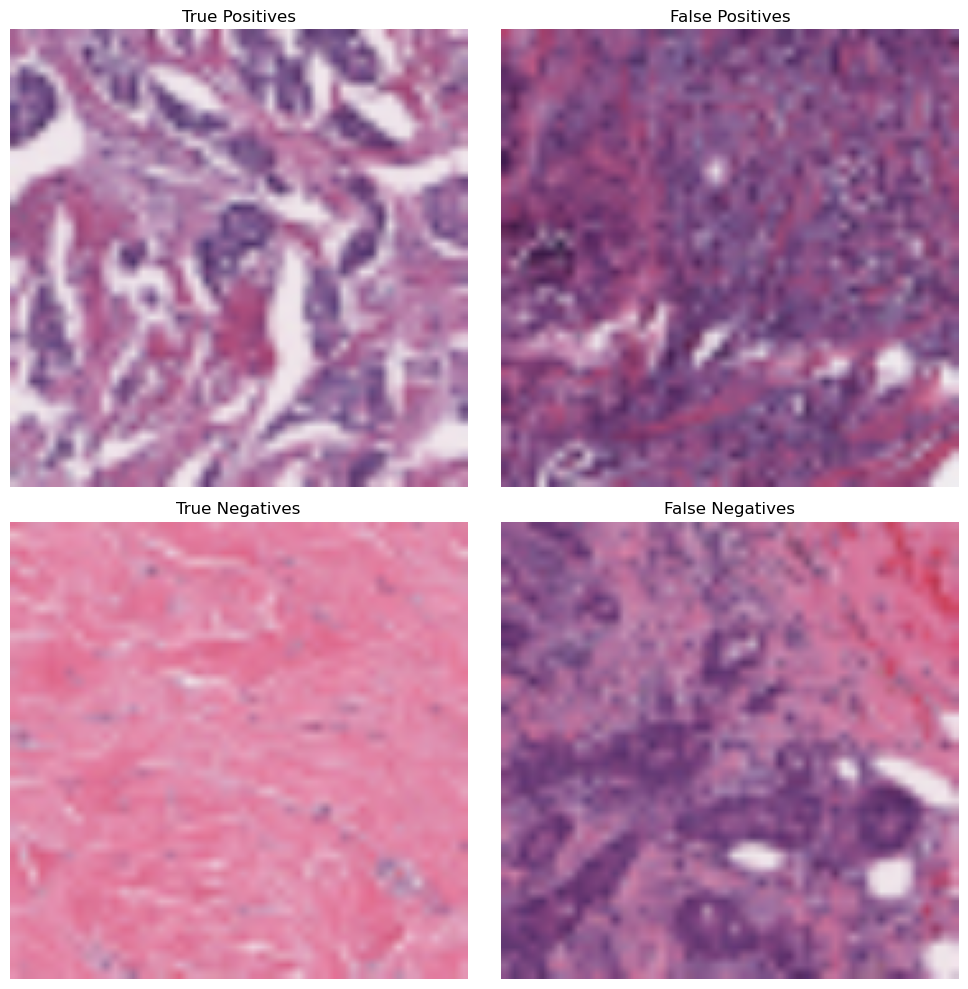

In [106]:
import matplotlib.pyplot as plt

# Define your TP_indices, FP_indices, TN_indices, FN_indices
# based on your classifier's predictions and true labels

# Create a figure with subplots
fig_cnn_sce, axes_cnn_sce = plt.subplots(2, 2, figsize=(10, 10))

# Loop through the test dataset to visualize images
for images_cnn_sce, labels_cnn_sce in test_ds.take(1):
    for i in range(images_cnn_sce.shape[0]):
        # Check if the image is a TP, FP, TN, or FN based on indices
        if i in TP_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[0, 0]
            title_cnn_sce = "True Positives"
        elif i in FP_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[0, 1]
            title_cnn_sce = "False Positives"
        elif i in TN_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[1, 0]
            title_cnn_sce = "True Negatives"
        elif i in FN_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[1, 1]
            title_cnn_sce = "False Negatives"
        
        # Display the image in the corresponding subplot
        ax_cnn_sce.imshow(images_cnn_sce[i].numpy())
        ax_cnn_sce.set_title(title_cnn_sce)
        ax_cnn_sce.axis("off")

plt.tight_layout()
plt.show()

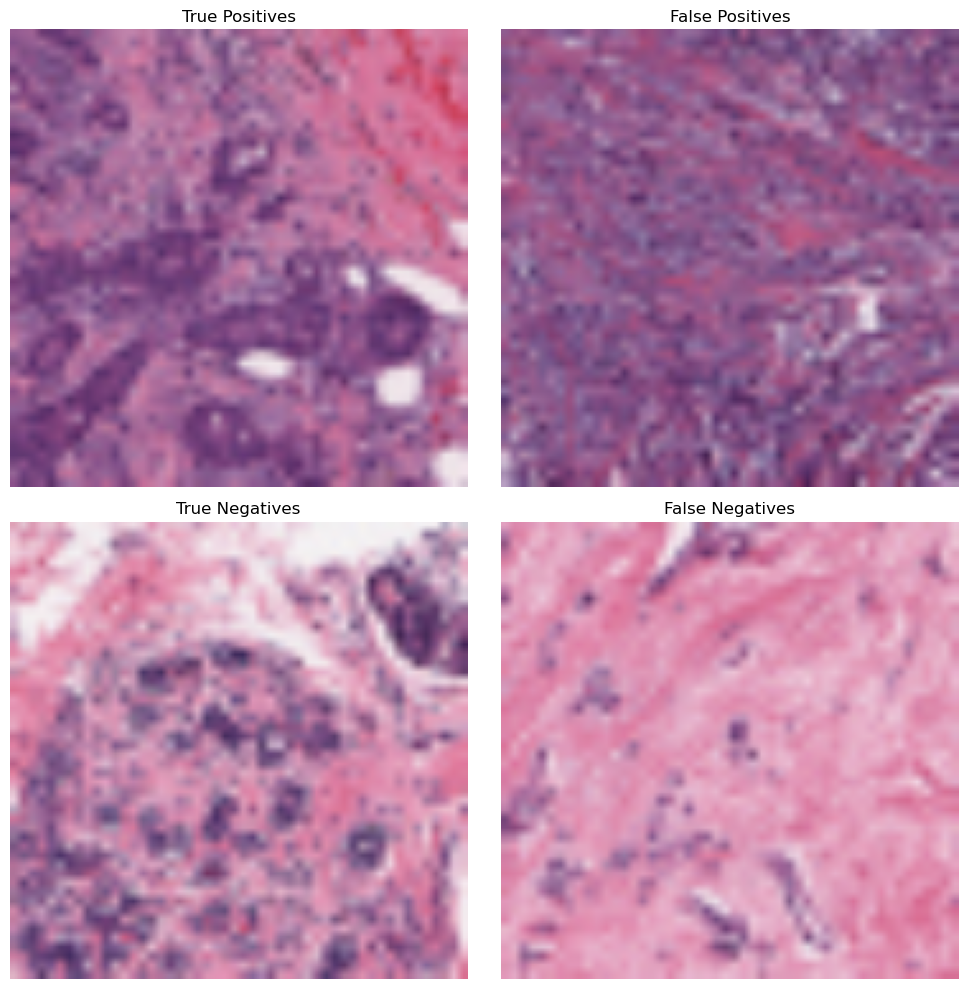

In [61]:
import matplotlib.pyplot as plt

# Define your TP_indices, FP_indices, TN_indices, FN_indices
# based on your classifier's predictions and true labels

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Loop through the test dataset to visualize images
for images, labels in test_ds.take(1):
    for i in range(images.shape[0]):
        # Check if the image is a TP, FP, TN, or FN based on indices
        if i in TP_indices:
            ax = axes[0, 0]
            title = "True Positives"
        elif i in FP_indices:
            ax = axes[0, 1]
            title = "False Positives"
        elif i in TN_indices:
            ax = axes[1, 0]
            title = "True Negatives"
        elif i in FN_indices:
            ax = axes[1, 1]
            title = "False Negatives"
        
        # Display the image in the corresponding subplot
        ax.imshow(images[i].numpy())
        ax.set_title(title)
        ax.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(save_folder, f"{title}_{i}.png"))
plt.show()

### Testing the model

In [293]:
b_image1 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/benign/x151_y1601_class0.png"
b_image2 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/benign/x101_y901_class0.png"
b_image3 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/benign/x201_y501_class0.png"
b_image4 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/benign/x151_y401_class0.png"
b_image5 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/benign/x1551_y1801_class0.png"
m_image1 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/malignant/x701_y901_class1.png"
m_image2 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/malignant/x951_y951_class1.png"
m_image3 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/malignant/x1701_y1551_class1.png"
m_image4 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/malignant/x451_y1401_class1.png"
m_image5 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/malignant/x1401_y1551_class1.png"

In [289]:
from PIL import Image
model_scepath = "bc_modelTLsce.h5"
load_scemodel = tf.keras.models.load_model(model_scepath)

test_image = cv2.imread(m_image1)
imagearray = Image.fromarray(test_image, 'RGB')
imageresize = imagearray.resize((img_height, img_width))
imageexpand = np.expand_dims(imageresize, axis=0)
test_input = np.array(imageexpand)
test_input = test_input/255

#using the saved model to predict the test images
pred = load_scemodel.predict(test_input)

# Selecting a threshold (e.g., 0.5)
threshold = 0.5

# Using np.where to classify the samples
predictions = np.where(pred[0][1] > threshold, 'malignant', 'benign')

# Print the classification results
print(predictions)

1/1 [==============================] - 1s 651ms/step
malignant


In [302]:
from PIL import Image
model_scepath = "bc_model2TLsce.h5"
load_scemodel = tf.keras.models.load_model(model_scepath)

test_image = cv2.imread(m_image2)
imagearray = Image.fromarray(test_image, 'RGB')
imageresize = imagearray.resize((img_height, img_width))
imageexpand = np.expand_dims(imageresize, axis=0)
test_input = np.array(imageexpand)
test_input = test_input/255

#using the saved model to predict the test images
pred = load_scemodel.predict(test_input)

# Selecting a threshold (e.g., 0.5)
threshold = 0.5

# Using np.where to classify the samples
predictions = np.where(pred[0][0] > threshold, 'malignant', 'benign')

# Print the classification results
print(predictions)

1/1 [==============================] - 0s 169ms/step
malignant


In [ ]:
# Result:
# For beningn images: Out of 5 images, 4 were predicted correctly as benign and 1 incorrectly as malignant
# For malignant images: Out of 5 images, 3 were predicted correctly as malignant and 2 incorrectly as benign

# STANDARD ERROR RATE FOR VGG16-SCE

In [81]:
import math

In [194]:
train_loss2

0.1010696217417717

In [306]:
#VGG16 sparsecategoricalcrossentropy
vggscetrain_num = (1-train_loss)
len_vscetrain_ds = len(train_ds)*batch_size
train1_error_vsce = (train_loss) - 1.96 * math.sqrt((train_loss*vggscetrain_num)/len_vscetrain_ds)
train2_error_vsce = (train_loss) + 1.96 * math.sqrt((train_loss*vggscetrain_num)/len_vscetrain_ds)

print(f'{train1_error_vsce:.4f} - {train2_error_vsce:.4f}')

0.0952 - 0.1069


In [307]:
vggsceval_num = (1-val_loss)
len_vsceval_ds = len(val_ds)*batch_size
val1_error_vsce = (val_loss) - 1.96 * math.sqrt(val_loss*(vggsceval_num/len_vsceval_ds))
val2_error_vsce = (val_loss) + 1.96 * math.sqrt(val_loss*(vggsceval_num/len_vsceval_ds))

print(f'{val1_error_vsce:.4f} - {val2_error_vsce:.4f}')

0.1943 - 0.2258


In [308]:
vggscetest_num = (1-test_loss)
len_vscetest_ds = len(test_ds)*batch_size
test1_error_vsce = (test_loss) - 1.96 * math.sqrt(test_loss*(vggscetest_num/len_vscetest_ds))
test2_error_vsce = (test_loss) + 1.96 * math.sqrt(test_loss*(vggscetest_num/len_vscetest_ds))

print(f'{test1_error_vsce:.4f} - {test2_error_vsce:.4f}')

0.0901 - 0.1244


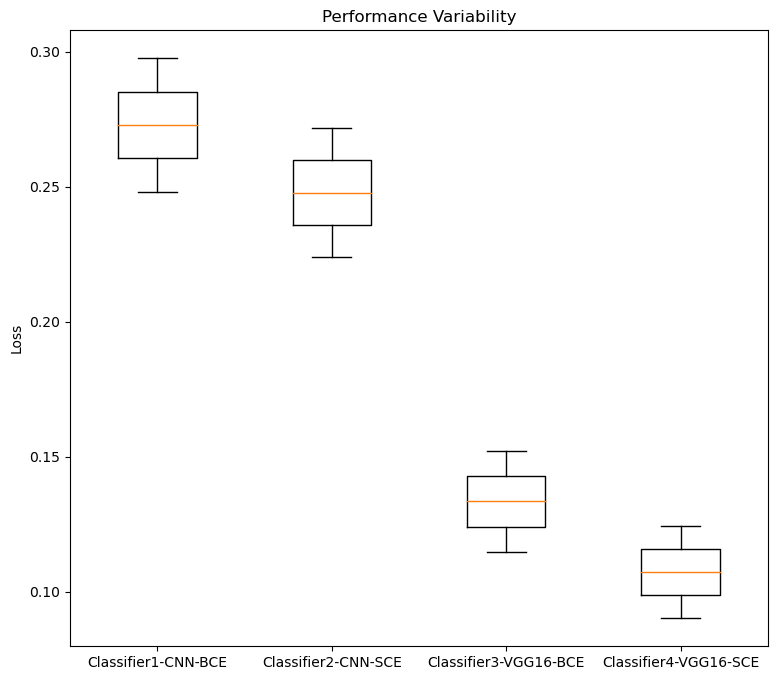

In [309]:
# Create a figure to adjust the width
plt.figure(figsize=(9, 8)) 

# Create the boxplot to visualize with error bars
plt.boxplot([[test1_error_cbce, test2_error_cbce], [test1_error_csce, test2_error_csce], [test1_error_vbce, test2_error_vbce], [test1_error_vsce, test2_error_vsce]], labels=['Classifier1-CNN-BCE', 'Classifier2-CNN-SCE', 'Classifier3-VGG16-BCE', 'Classifier4-VGG16-SCE'])
plt.ylabel('Loss')
plt.title('Performance Variability')
plt.savefig(os.path.join(save_folder, 'Error bar performance analysis.png'))
plt.show()


# TESTING THE MODEL - PRESENTATION

In [175]:
b_image1 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/benign/x151_y1601_class0.png"
b_image2 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/benign/x101_y901_class0.png"
b_image3 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/benign/x201_y501_class0.png"
b_image4 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/benign/x151_y401_class0.png"
b_image5 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/benign/x1551_y1801_class0.png"
m_image1 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/malignant/x701_y901_class1.png"
m_image2 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/malignant/x951_y951_class1.png"
m_image3 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/malignant/x1701_y1551_class1.png"
m_image4 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/malignant/x451_y1401_class1.png"
m_image5 = "/Users/opeoluwa/Downloads/dissertation_project/prediction_test_images/malignant/x1401_y1551_class1.png"

In [324]:
from PIL import Image
model_scepath = "bc_model2TLsce.h5"
load_scemodel = tf.keras.models.load_model(model_scepath)

test_image = cv2.imread(m_image3)
imagearray = Image.fromarray(test_image, 'RGB')
imageresize = imagearray.resize((img_height, img_width))
imageexpand = np.expand_dims(imageresize, axis=0)
test_input = np.array(imageexpand)
test_input = test_input/255

#using the saved model to predict the test images
pred = load_scemodel.predict(test_input)

# Selecting a threshold (e.g., 0.5)
threshold = 0.5

# # Using np.where to classify the samples
# predictions = np.where(pred[0][1] >= threshold, 'malignant', 'benign')

# # Print the classification results
# print(predictions)

1/1 [==============================] - 0s 177ms/step


In [325]:
print(pred)

[[0.07505287 0.8070347 ]]


In [326]:
# Using np.where to classify the samples
predictions = np.where(pred[0][1] >= threshold, 'malignant', 'benign')

# Print the classification results
print(predictions)

malignant


In [327]:
predicted_probabilities = pred[0]  # Get the probabilities for the first sample
threshold = 0.5  # Choose a threshold

# # Classify the sample based on the threshold
prediction = 'malignant' if predicted_probabilities[1] >= threshold else 'benign'

# # Print the classification result
print(prediction)

malignant


## Base model 2 

Using:

1. X numbeer of epochs-100
2. BinaryCrossentropy --sigmoid

In [127]:
num_classes = 1

In [128]:
# Create the feature extraction model with data augmentation
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
outputs = keras.layers.Dense(num_classes, activation='sigmoid')(x)
model_bce = keras.Model(inputs, outputs)

In [129]:
model_bce.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                           

In [130]:
model_bce.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [131]:
# Implement early stopping based on validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with class weighting
class_weight = {0: 1.0, 1: 2.0}  # Class weight for addressing class imbalance

In [132]:
# Re-train the model with the new optimizer
epochs = 100
history_bce = model_bce.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[lr_callback, early_stopping],
    class_weight=class_weight
)

Epoch 1/100
318/318 [==============================] - 2035s 6s/step - loss: 0.2639 - accuracy: 0.9157 - val_loss: 0.2095 - val_accuracy: 0.9205 - lr: 1.0000e-04
Epoch 2/100
318/318 [==============================] - 2166s 7s/step - loss: 0.2495 - accuracy: 0.9222 - val_loss: 0.2066 - val_accuracy: 0.9165 - lr: 1.0000e-04
Epoch 3/100
318/318 [==============================] - 2251s 7s/step - loss: 0.2383 - accuracy: 0.9220 - val_loss: 0.1975 - val_accuracy: 0.9217 - lr: 1.0000e-04
Epoch 4/100
318/318 [==============================] - 2435s 8s/step - loss: 0.2367 - accuracy: 0.9250 - val_loss: 0.1959 - val_accuracy: 0.9260 - lr: 1.0000e-04
Epoch 5/100
318/318 [==============================] - 2302s 7s/step - loss: 0.2240 - accuracy: 0.9296 - val_loss: 0.1919 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 6/100
318/318 [==============================] - 2694s 8s/step - loss: 0.2093 - accuracy: 0.9344 - val_loss: 0.2179 - val_accuracy: 0.9161 - lr: 1.0000e-04
Epoch 7/100
318/318 [=======

In [139]:
# model_bce.save(os.path.join(save_folder, "bc_modelTLbce.keras"))
model_bce.save("bc_modelTLbce.h5")
    

/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [140]:
# Evaluate the model on the training subset
train_loss_bce, train_accuracy_bce = model.evaluate(train_ds)
print(f"Train Loss: {train_loss_bce}")
print(f"Train Accuracy: {train_accuracy_bce}")

318/318 [==============================] - 1279s 4s/step - loss: 0.1274 - accuracy: 0.9473
Train Loss: 0.1273525059223175
Train Accuracy: 0.9472648501396179


In [141]:
# Evaluate the model on the validation subset
val_loss_bce, val_accuracy_bce = model_bce.evaluate(val_ds)
print(f"Val Loss: {val_loss_bce}")
print(f"Val Accuracy: {val_accuracy_bce}")

80/80 [==============================] - 432s 5s/step - loss: 0.1919 - accuracy: 0.9256
Val Loss: 0.19194066524505615
Val Accuracy: 0.9255905747413635


In [142]:
# Evaluate the model on the testing subset
test_loss_bce, test_accuracy_bce = model_bce.evaluate(test_ds)
print(f"Test Loss: {test_loss_bce}")
print(f"Test Accuracy: {test_accuracy_bce}")

39/39 [==============================] - 213s 5s/step - loss: 0.1334 - accuracy: 0.9447
Test Loss: 0.1333804428577423
Test Accuracy: 0.9447115659713745


In [143]:
# Confusion Matrix visualization function
def plot_confusion_matrix_bce(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(save_folder, f'Confusion_MAtrix, epochs:{epochs}, loss_function: BinaryCrossentropy.png'))
    plt.show()

In [144]:
# ROC Curve plotting function
def plot_roc_curve_bce(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(save_folder, f'ROC_CVurve, epochs:{epochs}, loss_function: BinaryCrossentropy.png'))
    plt.show()

In [145]:
# Get the predicted probabilities and true labels
y_scores_bce = model_bce.predict(test_ds)
y_pred_bce = np.argmax(y_scores_bce, axis=1)
y_true_bce = np.concatenate([y for x, y in test_ds], axis=0)

39/39 [==============================] - 214s 5s/step


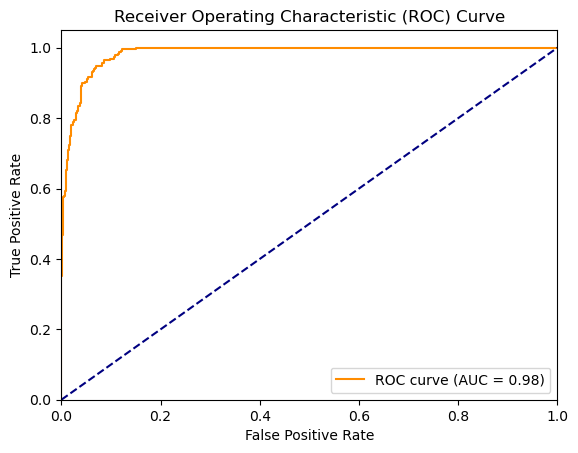

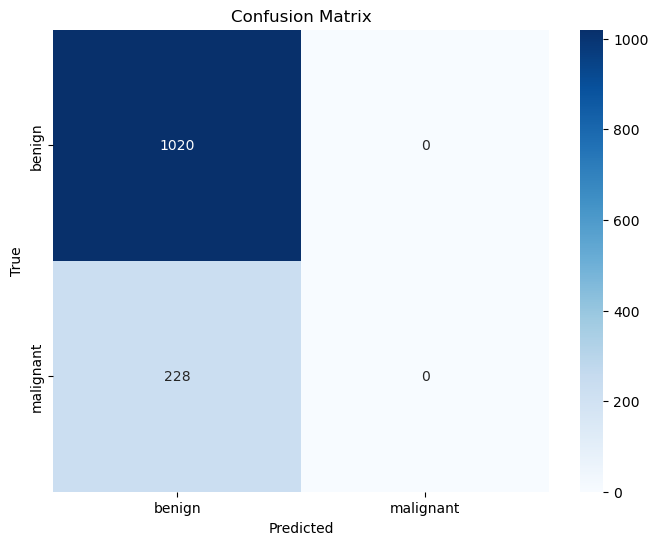

In [146]:
# Plot ROC curve
plot_roc_curve_bce(y_true_bce, y_scores_bce)
# Plot Confusion Matrix
plot_confusion_matrix_bce(y_true_bce, y_pred_bce)

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,precision_score,recall_score

In [149]:
report_bce = classification_report(y_true_bce, y_pred_bce, target_names=class_names)
conf_matrix_bce = confusion_matrix(y_true_bce, y_pred_bce)
TN_bce, FP_bce, FN_bce, TP_bce = conf_matrix_bce.ravel()
precision_bce = precision_score(y_true_bce, y_pred_bce)
specificity_bce = TN_bce/(TN_bce+FP_bce)
sensitivity_bce = recall_score(y_true_bce, y_pred_bce)


print(f'Sensitivity: {sensitivity_bce}')
print(f'Precision: {precision_bce}')
print(f'Specificity: {specificity_bce}')

print('\n',report_bce)

Sensitivity: 0.0
Precision: 0.0
Specificity: 1.0

               precision    recall  f1-score   support

      benign       0.82      1.00      0.90      1020
   malignant       0.00      0.00      0.00       228

    accuracy                           0.82      1248
   macro avg       0.41      0.50      0.45      1248
weighted avg       0.67      0.82      0.74      1248



/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/opeoluwa/ana

In [150]:
TP_indices_bce = []
FP_indices_bce = []
TN_indices_bce = []
FN_indices_bce = []

for i in range(len(y_true_bce)):
    true_label_bce = y_true_bce[i]
    predicted_label_bce = y_pred_bce[i]
    
    if true_label_bce == 1 and predicted_label_bce == 1:  # True Positive
        TP_indices_bce.append(i)
    elif true_label_bce == 0 and predicted_label_bce == 1:  # False Positive
        FP_indices_bce.append(i)
    elif true_label_bce == 0 and predicted_label_bce == 0:  # True Negative
        TN_indices_bce.append(i)
    elif true_label_bce == 1 and predicted_label_bce == 0:  # False Negative
        FN_indices_bce.append(i)

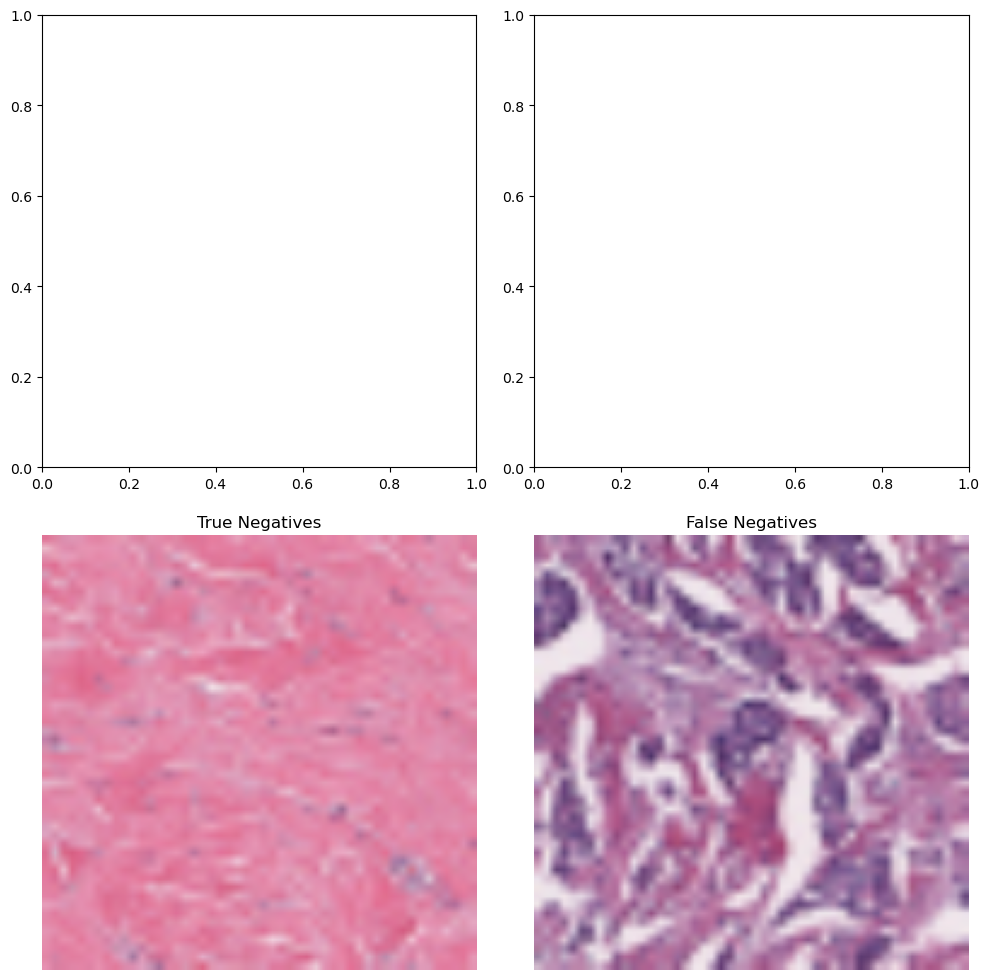

In [68]:
import matplotlib.pyplot as plt

# Define your TP_indices, FP_indices, TN_indices, FN_indices
# based on your classifier's predictions and true labels

# Create a figure with subplots
fig_bce, axes_bce = plt.subplots(2, 2, figsize=(10, 10))

# Loop through the test dataset to visualize images
for images_bce, labels_bce in test_ds.take(1):
    for i_bce in range(images_bce.shape[0]):
        # Check if the image is a TP, FP, TN, or FN based on indices
        if i_bce in TP_indices_bce:
            ax_bce = axes_bce[0, 0]
            title_bce = "True Positives"
        elif i_bce in FP_indices_bce:
            ax_bce = axes_bce[0, 1]
            title_bce = "False Positives"
        elif i_bce in TN_indices_bce:
            ax_bce = axes_bce[1, 0]
            title_bce = "True Negatives"
        elif i_bce in FN_indices_bce:
            ax_bce = axes_bce[1, 1]
            title_bce = "False Negatives"
        
        # Display the image in the corresponding subplot
        ax_bce.imshow(images_bce[i_bce].numpy())
        ax_bce.set_title(title_bce)
        ax_bce.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(save_folder, f"{title_bce}_{i_bce}.png"))
plt.show()

### Testing the model

In [71]:
model_bcepath = "bc_modelTLbce.h5"
load_bcemodel = tf.keras.models.load_model(model_bcepath)

# test_image_bce = cv2.imread("/Users/opeoluwa/Downloads/dissertation_project/BreastHistopathologyImages/16896/0/16896_idx5_x101_y651_class0.png")
# test_image_bce = cv2.imread("/Users/opeoluwa/Downloads/dissertation_project/BreastHistopathologyImages/16896/0/16896_idx5_x101_y951_class0.png")
test_image_bce = cv2.imread("/Users/opeoluwa/Downloads/dissertation_project/BreastHistopathologyImages/16896/1/16896_idx5_x201_y801_class1.png")
imagearray_bce = Image.fromarray(test_image_bce, 'RGB')
imageresize_bce = imagearray_bce.resize((img_height, img_width))
imageexpand_bce = np.expand_dims(imageresize_bce, axis=0)
test_input_bce = np.array(imageexpand_bce)
test_input_bce = test_input_bce/255


pred_bce = load_bcemodel.predict(test_input_bce)
# if pred_bce >=0.5:
#     print('malignant')
# else:
#     print('benign')
    

    
# Choose a threshold (e.g., 0.5)
threshold_bce = 0.5

# Use np.where to classify the samples
predictions_bce = np.where(pred_bce >= threshold_bce, 'malignant', 'benign')

# Print the classification results
print(predictions_bce)


1/1 [==============================] - 0s 110ms/step
[['benign']]


# VGG16 BCE- STANDARD ERROR RATE

In [188]:
train_loss_bce

0.1273525059223175

In [319]:
#VGG16 sparsecategoricalcrossentropy
vggbcetrain_num = (1-train_loss_bce)
len_vggbcetrain_ds = len(train_ds)*batch_size
train1_error_vbce = (train_loss_bce) - 1.96 * math.sqrt((train_loss_bce*vggbcetrain_num)/len_vggbcetrain_ds)
train2_error_vbce = (train_loss_bce) + 1.96 * math.sqrt((train_loss_bce*vggbcetrain_num)/len_vggbcetrain_ds)

print(f'{train1_error_vbce:.4f} - {train2_error_vbce:.4f}')

0.1209 - 0.1338


In [ ]:
val_loss_vbce_loss = 0.2085

In [192]:
vggbceval_num = (1-val_loss_bce)
len_vggbceval_ds = len(val_ds)*batch_size
val1_error_vbce = (val_loss_bce) - 1.96 * math.sqrt(val_loss_bce*(vggbceval_num/len_vggbceval_ds))
val2_error_vbce = (val_loss_bce) + 1.96 * math.sqrt(val_loss_bce*(vggbceval_num/len_vggbceval_ds))

print(f'{val1_error_vbce:.4f} - {val2_error_vbce:.4f}')

0.1767 - 0.2072


In [ ]:
test_loss_vbce_loss = 0.2070

In [193]:
vggbcetest_num = (1-test_loss_bce)
len_vggbcetest_ds = len(test_ds)*batch_size
test1_error_vbce = (test_loss_bce) - 1.96 * math.sqrt(test_loss_bce*(vggbcetest_num/len_vggbcetest_ds))
test2_error_vbce = (test_loss_bce) + 1.96 * math.sqrt(test_loss_bce*(vggbcetest_num/len_vggbcetest_ds))

print(f'{test1_error_vbce:.4f} - {test2_error_vbce:.4f}')

0.1145 - 0.1522


# Deep Learning Model using CNN

# binary_crossentropy ---100

In [72]:
# Create the CNN model
model_cnn_bce = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')
])

In [73]:
model_cnn_bce.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)      

In [74]:
# Compile the model
model_cnn_bce.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [75]:
# Train the CNN model
epochs_cnn = 100
history_cnn_bce = model_cnn_bce.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_cnn,
    callbacks=[lr_callback, early_stopping],
    class_weight=class_weight
)

Epoch 1/100
318/318 [==============================] - 109s 342ms/step - loss: 0.5486 - accuracy: 0.8423 - val_loss: 0.5669 - val_accuracy: 0.7130 - lr: 1.0000e-04
Epoch 2/100
318/318 [==============================] - 115s 360ms/step - loss: 0.4485 - accuracy: 0.8584 - val_loss: 0.2962 - val_accuracy: 0.8740 - lr: 1.0000e-04
Epoch 3/100
318/318 [==============================] - 124s 388ms/step - loss: 0.4270 - accuracy: 0.8645 - val_loss: 0.2796 - val_accuracy: 0.8827 - lr: 1.0000e-04
Epoch 4/100
318/318 [==============================] - 130s 407ms/step - loss: 0.4042 - accuracy: 0.8693 - val_loss: 0.2652 - val_accuracy: 0.8862 - lr: 1.0000e-04
Epoch 5/100
318/318 [==============================] - 121s 379ms/step - loss: 0.3978 - accuracy: 0.8747 - val_loss: 0.2653 - val_accuracy: 0.8843 - lr: 1.0000e-04
Epoch 6/100
318/318 [==============================] - 121s 382ms/step - loss: 0.3960 - accuracy: 0.8755 - val_loss: 0.2536 - val_accuracy: 0.9020 - lr: 1.0000e-04
Epoch 7/100
318/

In [76]:
model_cnn_bce.save("bc_modelCNNbce.h5")

/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
# Evaluate the CNN model with the changed loss function on the training subset
train_loss_cnn_bce, train_accuracy_cnn_bce = model_cnn_bce.evaluate(train_ds)
print(f"Train loss (CNN): {train_loss_cnn_bce}")
print(f"Train accuracy (CNN): {train_accuracy_cnn_bce}")

318/318 [==============================] - 35s 109ms/step - loss: 0.2455 - accuracy: 0.8941
Train loss (CNN): 0.24546368420124054
Train accuracy (CNN): 0.8941361904144287


In [78]:
# Evaluate the CNN model
val_loss_cnn_bce, val_accuracy_cnn_bce = model_cnn_bce.evaluate(val_ds)
print(f"Validation loss (CNN): {val_loss_cnn_bce}")
print(f"Validation accuracy (CNN): {val_accuracy_cnn_bce}")

80/80 [==============================] - 9s 114ms/step - loss: 0.2536 - accuracy: 0.9020
Validation loss (CNN): 0.25364845991134644
Validation accuracy (CNN): 0.9019684791564941


In [79]:
# Evaluate the CNN model
test_loss_cnn_bce, test_accuracy_cnn_bce = model_cnn_bce.evaluate(test_ds)
print(f"Test loss (CNN): {test_loss_cnn_bce}")
print(f"Test accuracy (CNN): {test_accuracy_cnn_bce}")

39/39 [==============================] - 4s 107ms/step - loss: 0.2729 - accuracy: 0.8734
Test loss (CNN): 0.27287253737449646
Test accuracy (CNN): 0.8733974099159241


In [80]:
# ROC Curve plotting function (for the CNN model)
def plot_roc_curve_cnn_bce(y_true_cnn_bce, y_score_cnn_bce):
    fpr_cnn_bce, tpr_cnn_bce, thresholds_cnn_bce = roc_curve(y_true_cnn_bce, y_score_cnn_bce)
    roc_auc_cnn_bce = auc(fpr_cnn_bce, tpr_cnn_bce)

    plt.figure()
    plt.plot(fpr_cnn_bce, tpr_cnn_bce, color='darkorange', label=f'ROC curve (AUC = {roc_auc_cnn_bce:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (CNN)')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(save_folder, f'ROC_CVurve, epochs:{epochs_cnn}, loss_function: BinaryCrossentropy.png'))
    plt.show()

In [81]:
# Confusion Matrix visualization function (for the CNN model)
def plot_confusion_matrix_cnn_bce(y_true_cnn_bce, y_pred_cnn_bce):
    cm_cnn_bce = confusion_matrix(y_true_cnn_bce, y_pred_cnn_bce)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_cnn_bce, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix (CNN)')
    plt.savefig(os.path.join(save_folder, f'Confusion_MAtrix, epochs:{epochs}, loss_function: BinaryCrossentropy.png'))
    plt.show()

In [82]:
# Get the predicted probabilities and true labels for the CNN model
y_scores_cnn_bce = model_cnn_bce.predict(test_ds)
y_pred_cnn_bce = np.argmax(y_scores_cnn_bce, axis=1)
y_true_cnn_bce = np.concatenate([y for x, y in test_ds], axis=0)

39/39 [==============================] - 4s 103ms/step


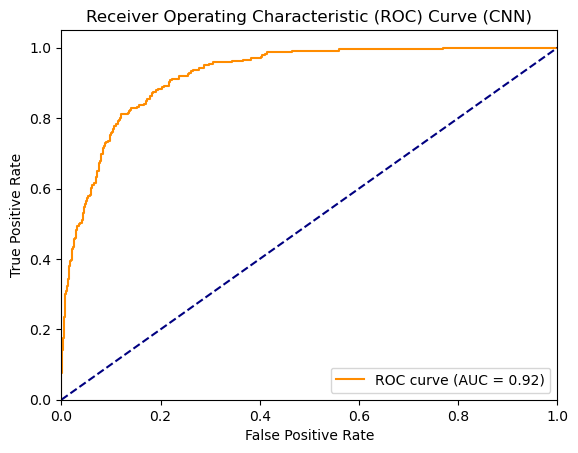

In [83]:
# Plot ROC curve for the CNN model
plot_roc_curve_cnn_bce(y_true_cnn_bce, y_scores_cnn_bce)

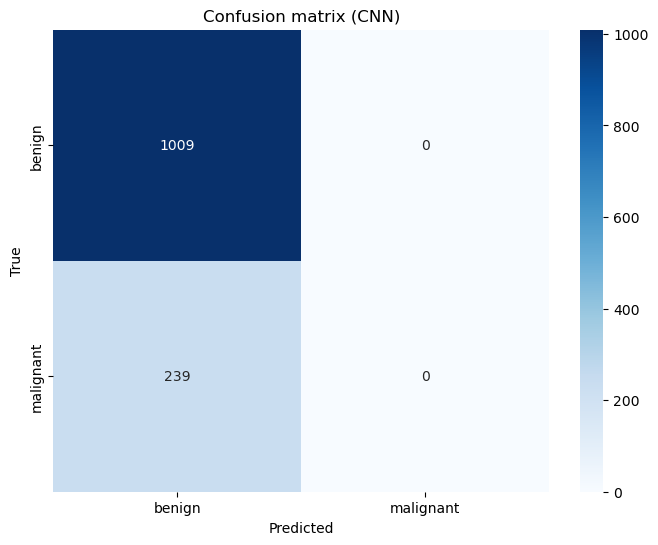

In [84]:
# Plot Confusion Matrix for the CNN model
plot_confusion_matrix_cnn_bce(y_true_cnn_bce, y_pred_cnn_bce)

In [85]:
report_cnn_bce = classification_report(y_true_cnn_bce, y_pred_cnn_bce, target_names=class_names)
conf_matrix_cnn_bce = confusion_matrix(y_true_cnn_bce, y_pred_cnn_bce)
TN_cnn_bce, FP_cnn_bce, FN_cnn_bce, TP_cnn_bce = conf_matrix.ravel()
precision_cnn_bce = precision_score(y_true_cnn_bce, y_pred_cnn_bce)
specificity_cnn_bce = TN_cnn_bce/(TN_cnn_bce+FP_cnn_bce)
sensitivity_cnn_bce = recall_score(y_true_cnn_bce, y_pred_cnn_bce)


print(f'Sensitivity: {sensitivity_cnn_bce}')
print(f'Precision: {precision_cnn_bce}')
print(f'Specificity: {specificity_cnn_bce}')

print('\n',report_cnn_bce)

Sensitivity: 0.0
Precision: 0.0
Specificity: 0.9415262636273538

               precision    recall  f1-score   support

      benign       0.81      1.00      0.89      1009
   malignant       0.00      0.00      0.00       239

    accuracy                           0.81      1248
   macro avg       0.40      0.50      0.45      1248
weighted avg       0.65      0.81      0.72      1248



/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/opeoluwa/ana

In [86]:
TP_indices_cnn_bce = []
FP_indices_cnn_bce = []
TN_indices_cnn_bce = []
FN_indices_cnn_bce = []

for i_cnn_bce in range(len(y_true_cnn_bce)):
    true_label_cnn_bce = y_true_cnn_bce[i_cnn_bce]
    predicted_label_cnn_bce = y_pred_cnn_bce[i_cnn_bce]
    
    if true_label_cnn_bce == 1 and predicted_label_cnn_bce == 1:  # True Positive
        TP_indices_cnn_bce.append(i_cnn_bce)
    elif true_label_cnn_bce == 0 and predicted_label_cnn_bce == 1:  # False Positive
        FP_indices_cnn_bce.append(i_cnn_bce)
    elif true_label_cnn_bce == 0 and predicted_label_cnn_bce == 0:  # True Negative
        TN_indices_cnn_bce.append(i_cnn_bce)
    elif true_label_cnn_bce == 1 and predicted_label_cnn_bce == 0:  # False Negative
        FN_indices_cnn_bce.append(i_cnn_bce)

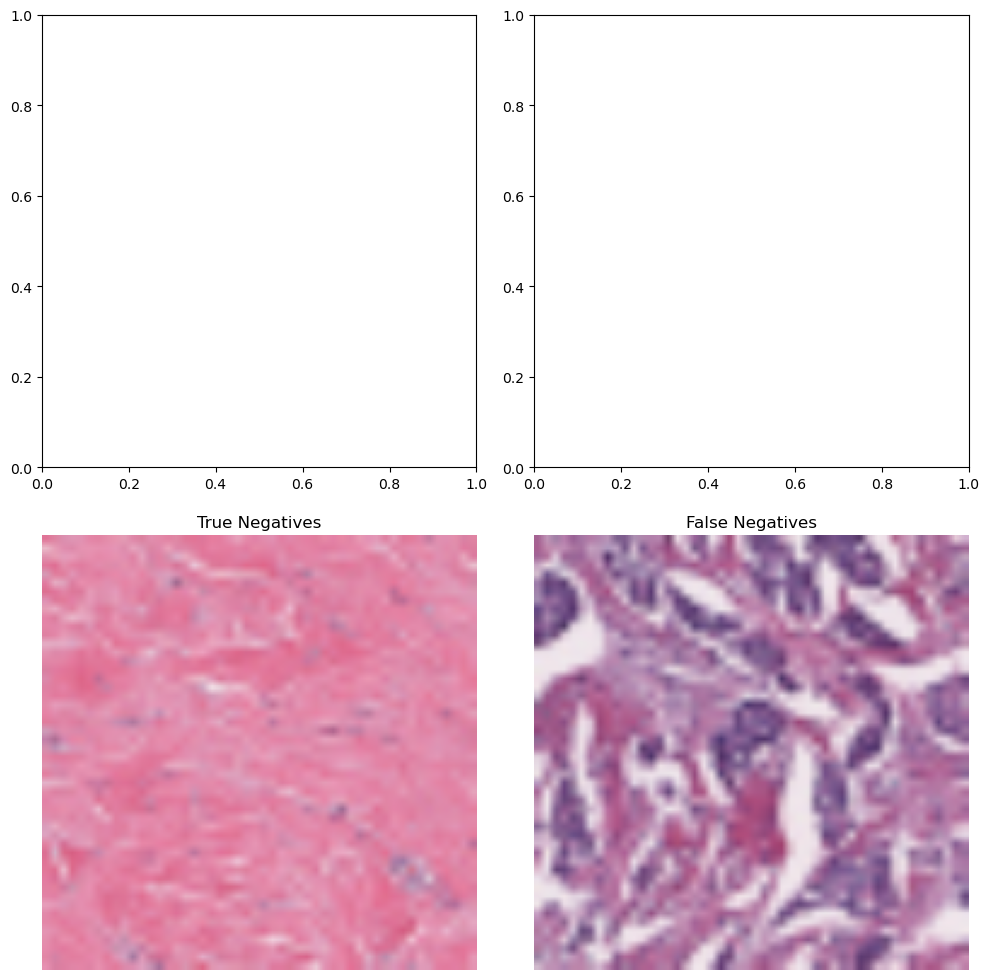

In [87]:
import matplotlib.pyplot as plt

# Define your TP_indices, FP_indices, TN_indices, FN_indices
# based on your classifier's predictions and true labels

# Create a figure with subplots
fig_cnn_bce, axes_cnn_bce = plt.subplots(2, 2, figsize=(10, 10))

# Loop through the test dataset to visualize images
for images_cnn_bce, labels_cnn_bce in test_ds.take(1):
    for i in range(images_cnn_bce.shape[0]):
        # Check if the image is a TP, FP, TN, or FN based on indices
        if i in TP_indices_cnn_bce:
            ax_cnn_bce = axes_cnn_bce[0, 0]
            title_cnn_bce = "True Positives"
        elif i in FP_indices_cnn_bce:
            ax_cnn_bce = axes_cnn_bce[0, 1]
            title_cnn_bce = "False Positives"
        elif i in TN_indices_cnn_bce:
            ax_cnn_bce = axes_cnn_bce[1, 0]
            title_cnn_bce = "True Negatives"
        elif i in FN_indices_cnn_bce:
            ax_cnn_bce = axes_cnn_bce[1, 1]
            title_cnn_bce = "False Negatives"
        
        # Display the image in the corresponding subplot
        ax_cnn_bce.imshow(images_cnn_bce[i].numpy())
        ax_cnn_bce.set_title(title_cnn_bce)
        ax_cnn_bce.axis("off")

plt.tight_layout()
plt.show()

### Testing the model

In [195]:
model_cnnbcepath = "bc_modelCNNbce.h5"
load_cnnbcemodel = tf.keras.models.load_model(model_cnnbcepath)

# test_image_cnn_bce = cv2.imread("/Users/opeoluwa/Downloads/dissertation_project/BreastHistopathologyImages/16896/0/16896_idx5_x101_y651_class0.png")
# test_image_cnn_bce = cv2.imread("/Users/opeoluwa/Downloads/dissertation_project/BreastHistopathologyImages/16896/0/16896_idx5_x101_y951_class0.png")
test_image_cnn_bce = cv2.imread("/Users/opeoluwa/Downloads/dissertation_project/BreastHistopathologyImages/16896/1/16896_idx5_x201_y801_class1.png")
imagearray_cnn_bce = Image.fromarray(test_image_cnn_bce, 'RGB')
imageresize_cnn_bce = imagearray_cnn_bce.resize((img_height, img_width))
imageexpand_cnn_bce = np.expand_dims(imageresize_cnn_bce, axis=0)
test_input_cnn_bce = np.array(imageexpand_cnn_bce)
test_input_cnn_bce = test_input_cnn_bce/255


pred_cnn_bce = load_cnnbcemodel.predict(test_input_cnn_bce)
# if pred_cnn_bce >=0.5:
#     print('malignant')
# else:
#     print('benign')
    

    
# Choose a threshold (e.g., 0.5)
threshold_cnn_bce = 0.5

# Use np.where to classify the samples
predictions_cnn_bce = np.where(pred_cnn_bce >= threshold_cnn_bce, 'malignant', 'benign')

# Print the classification results
print(predictions_cnn_bce)

1/1 [==============================] - 0s 29ms/step
[['malignant']]


# CNN BCE- STANDARD ERROR RATE

In [159]:
train_loss_cnn_bce_loss = 0.2455

In [185]:
#VGG16 sparsecategoricalcrossentropy
cnnbcetrain_num = (1 - train_loss_cnn_bce_loss)
len_cnnbcetrain_ds = len(train_ds)*batch_size
train1_error_cbce = (train_loss_cnn_bce_loss) - 1.96 * math.sqrt((train_loss_cnn_bce_loss * cnnbcetrain_num)/len_cnnbcetrain_ds)
train2_error_cbce = (train_loss_cnn_bce_loss) + 1.96 * math.sqrt((train_loss_cnn_bce_loss * cnnbcetrain_num)/len_cnnbcetrain_ds)

In [186]:
print(train1_error_cbce)
print(train2_error_cbce)

0.23713775490418673
0.25386224509581323


In [163]:
print(f'{train1_error_cbce:.4f} - {train2_error_cbce:.4f}')

0.2371 - 0.2539


In [164]:
val_loss_cnn_bce_loss = 0.2536

In [165]:
cnnbceval_num = (1-val_loss_cnn_bce_loss)
len_cnnbceval_ds = len(val_ds)*batch_size
val1_error_cbce = (val_loss_cnn_bce_loss) - 1.96 * math.sqrt(val_loss_cnn_bce_loss*(cnnbceval_num/len_cnnbceval_ds))
val2_error_cbce = (val_loss_cnn_bce_loss) + 1.96 * math.sqrt(val_loss_cnn_bce_loss*(cnnbceval_num/len_cnnbceval_ds))

print(f'{val1_error_cbce:.4f} - {val2_error_cbce:.4f}')

0.2367 - 0.2705


In [166]:
test_loss_cnn_bce_loss = 0.2729

In [167]:
cnnbcetest_num = (1 - test_loss_cnn_bce_loss)
len_cnnbcetest_ds = len(test_ds)*batch_size
test1_error_cbce = (test_loss_cnn_bce_loss) - 1.96 * math.sqrt(test_loss_cnn_bce_loss*(cnnbcetest_num/len_cnnbcetest_ds))
test2_error_cbce = (test_loss_cnn_bce_loss) + 1.96 * math.sqrt(test_loss_cnn_bce_loss*(cnnbcetest_num/len_cnnbcetest_ds))

print(f'{test1_error_cbce:.4f} - {test2_error_cbce:.4f}')

0.2482 - 0.2976


# SparseCategoricalCrossentropy-- 100

In [89]:
num_classes = 2

In [105]:
# Create the CNN model
model_cnn_sce = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')
])

In [106]:
# Compile the model
model_cnn_sce.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [107]:
# Train the CNN model
epochs_cnn = 100
history_cnn_sce = model_cnn_sce.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_cnn,
    callbacks=[lr_callback, early_stopping],
    class_weight=class_weight
)

Epoch 1/100
318/318 [==============================] - 259s 813ms/step - loss: 0.5535 - accuracy: 0.8423 - val_loss: 0.2813 - val_accuracy: 0.8839 - lr: 1.0000e-04
Epoch 2/100
318/318 [==============================] - 242s 762ms/step - loss: 0.4473 - accuracy: 0.8601 - val_loss: 0.2697 - val_accuracy: 0.8878 - lr: 1.0000e-04
Epoch 3/100
318/318 [==============================] - 255s 801ms/step - loss: 0.4308 - accuracy: 0.8645 - val_loss: 0.2828 - val_accuracy: 0.8787 - lr: 1.0000e-04
Epoch 4/100
318/318 [==============================] - 241s 758ms/step - loss: 0.4141 - accuracy: 0.8692 - val_loss: 0.2655 - val_accuracy: 0.8937 - lr: 1.0000e-04
Epoch 5/100
318/318 [==============================] - 238s 748ms/step - loss: 0.4155 - accuracy: 0.8689 - val_loss: 0.2689 - val_accuracy: 0.8898 - lr: 1.0000e-04
Epoch 6/100
318/318 [==============================] - 268s 843ms/step - loss: 0.3947 - accuracy: 0.8782 - val_loss: 0.2619 - val_accuracy: 0.8886 - lr: 1.0000e-04
Epoch 7/100
318/

In [108]:
model_cnn_sce.save("bc_modelCNNsce.h5")

/Users/opeoluwa/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [109]:
# Evaluate the CNN model with the changed loss function on the training subset
train_loss_cnn_sce, train_accuracy_cnn_sce = model_cnn_sce.evaluate(train_ds)
print(f"Train loss (Loss Change): {train_loss_cnn_sce}")
print(f"Train accuracy (Loss Change): {train_accuracy_cnn_sce}")

318/318 [==============================] - 57s 180ms/step - loss: 0.2305 - accuracy: 0.8969
Train loss (Loss Change): 0.23053434491157532
Train accuracy (Loss Change): 0.8968909978866577


In [110]:
# Evaluate the CNN model
val_loss_cnn_sce, val_accuracy_cnn_sce = model_cnn_sce.evaluate(val_ds)
print(f"Validation loss (CNN): {val_loss_cnn_sce}")
print(f"Validation accuracy (CNN): {val_accuracy_cnn_sce}")

80/80 [==============================] - 16s 195ms/step - loss: 0.2442 - accuracy: 0.9020
Validation loss (CNN): 0.24417521059513092
Validation accuracy (CNN): 0.9019684791564941


In [111]:
# Evaluate the CNN model
test_loss_cnn_sce, test_accuracy_cnn_sce = model_cnn_sce.evaluate(test_ds)
print(f"Test loss (CNN): {test_loss_cnn_sce}")
print(f"Test accuracy (CNN): {test_accuracy_cnn_sce}")

39/39 [==============================] - 7s 184ms/step - loss: 0.2478 - accuracy: 0.8814
Test loss (CNN): 0.24783019721508026
Test accuracy (CNN): 0.8814102411270142


In [112]:
# ROC Curve plotting function (for the CNN model)
def plot_roc_curve_cnn_sce(y_true_cnn_sce, y_score_cnn_sce):
    fpr_cnn_sce, tpr_cnn_sce, thresholds = roc_curve(y_true_cnn_sce, y_score_cnn_sce[:, 1])
    roc_auc_cnn_sce = auc(fpr_cnn_sce, tpr_cnn_sce)

    plt.figure()
    plt.plot(fpr_cnn_sce, tpr_cnn_sce, color='darkorange', label=f'ROC curve (AUC = {roc_auc_cnn_sce:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (CNN)')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(save_folder, f'ROC_Curve, epochs:{epochs_cnn}, loss_function: SparseCategoricalCrossEntropy.png'))
    plt.show()

In [113]:
# Confusion Matrix visualization function (for the CNN model)
def plot_confusion_matrix_cnn_sce(y_true_cnn_sce, y_pred_cnn_sce):
    cm_cnn_sce = confusion_matrix(y_true_cnn_sce, y_pred_cnn_sce)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_cnn_sce, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (CNN)')
    plt.savefig(os.path.join(save_folder, f'Confusion_Matrix, epochs:{epochs_cnn}, loss_function: SparseCategoricalCrossEntropy.png'))
    plt.show()

In [114]:
# Get the predicted probabilities and true labels for the CNN model
y_scores_cnn_sce = model_cnn_sce.predict(test_ds)
y_pred_cnn_sce = np.argmax(y_scores_cnn_sce, axis=1)
y_true_cnn_sce = np.concatenate([y for x, y in test_ds], axis=0)

39/39 [==============================] - 7s 163ms/step


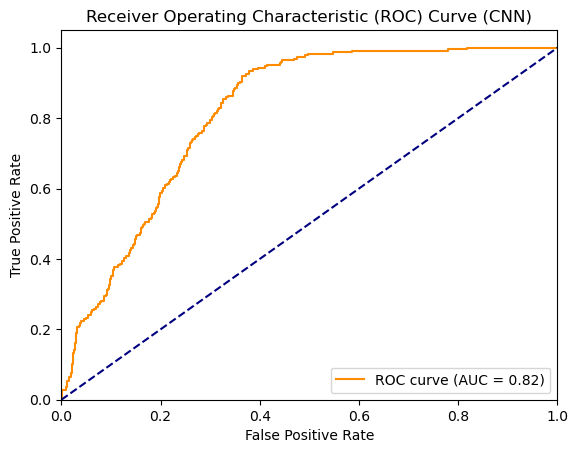

In [115]:
# Plot ROC curve for the CNN model
plot_roc_curve_cnn_sce(y_true_cnn_sce, y_scores_cnn_sce)

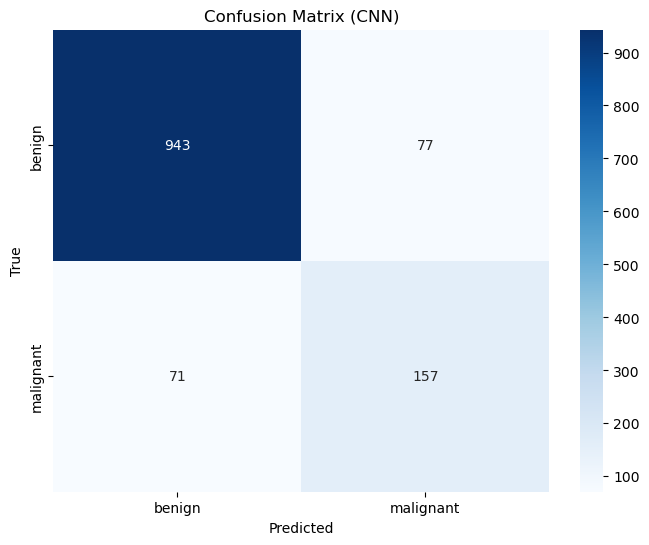

In [116]:
# Plot Confusion Matrix for the CNN model
plot_confusion_matrix_cnn_sce(y_true_cnn_sce, y_pred_cnn_sce)

In [118]:
report_cnn_sce = classification_report(y_true_cnn_sce, y_pred_cnn_sce, target_names=class_names)
conf_matrix_cnn_sce = confusion_matrix(y_true_cnn_sce, y_pred_cnn_sce)
TN_cnn_sce, FP_cnn_sce, FN_cnn_sce, TP_cnn_sce = conf_matrix_cnn_sce.ravel()
precision_cnn_sce = precision_score(y_true_cnn_sce, y_pred_cnn_sce)
specificity_cnn_sce = TN_cnn_sce/(TN_cnn_sce+FP_cnn_sce)
sensitivity_cnn_sce = recall_score(y_true_cnn_sce, y_pred_cnn_sce)


print(f'Sensitivity: {sensitivity_cnn_sce}')
print(f'Precision: {precision_cnn_sce}')
print(f'Specificity: {specificity_cnn_sce}')

print('\n',report_cnn_sce)

Sensitivity: 0.6885964912280702
Precision: 0.6709401709401709
Specificity: 0.9245098039215687

               precision    recall  f1-score   support

      benign       0.93      0.92      0.93      1020
   malignant       0.67      0.69      0.68       228

    accuracy                           0.88      1248
   macro avg       0.80      0.81      0.80      1248
weighted avg       0.88      0.88      0.88      1248



In [119]:
y_true_cnn_sce

array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

In [120]:
TP_indices_cnn_sce = []
FP_indices_cnn_sce = []
TN_indices_cnn_sce = []
FN_indices_cnn_sce = []

for i_cnn_sce in range(len(y_true_cnn_sce)):
    true_label_cnn_sce = y_true_cnn_sce[i_cnn_sce]
    predicted_label_cnn_sce = y_pred_cnn_sce[i_cnn_sce]
    
    if true_label_cnn_sce == 1 and predicted_label_cnn_sce == 1:  # True Positive
        TP_indices_cnn_sce.append(i_cnn_sce)
    elif true_label_cnn_sce == 0 and predicted_label_cnn_sce == 1:  # False Positive
        FP_indices_cnn_sce.append(i_cnn_sce)
    elif true_label_cnn_sce == 0 and predicted_label_cnn_sce == 0:  # True Negative
        TN_indices_cnn_sce.append(i_cnn_sce)
    elif true_label_cnn_sce == 1 and predicted_label_cnn_sce == 0:  # False Negative
        FN_indices_cnn_sce.append(i_cnn_sce)

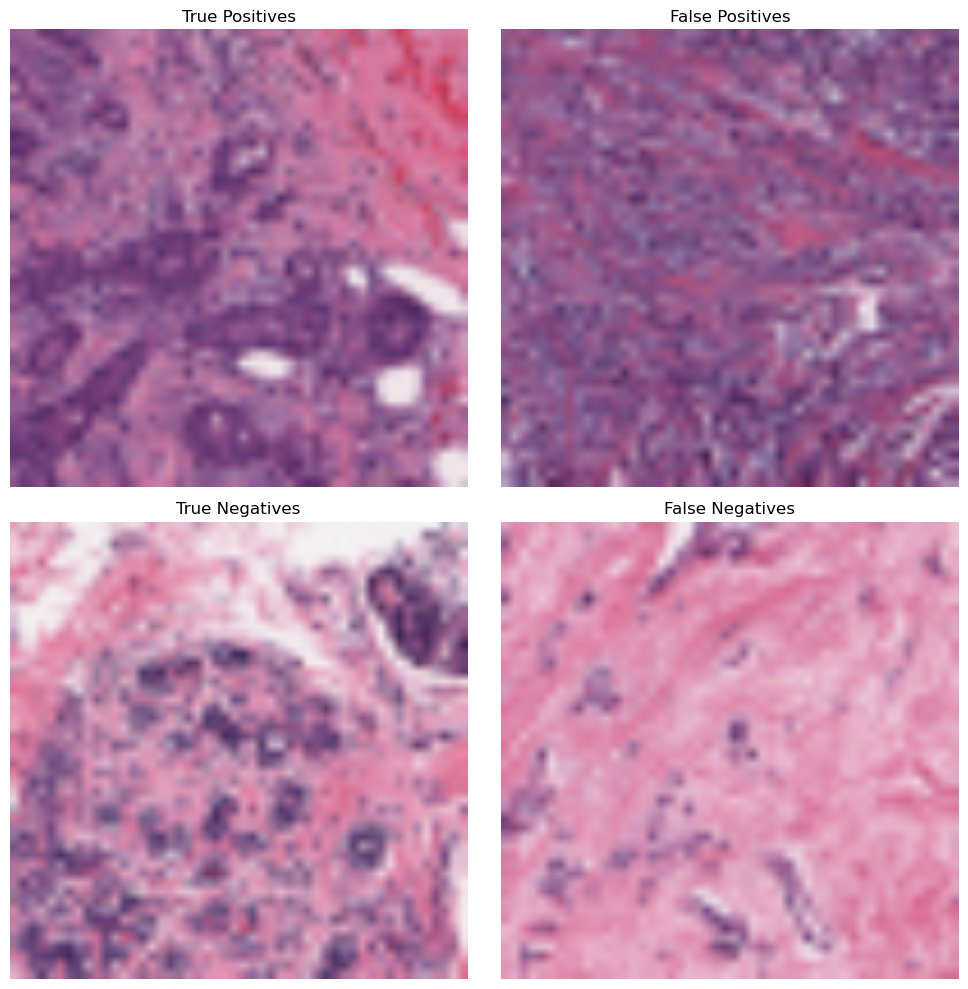

In [121]:
import matplotlib.pyplot as plt

# Define your TP_indices, FP_indices, TN_indices, FN_indices
# based on your classifier's predictions and true labels

# Create a figure with subplots
fig_cnn_sce, axes_cnn_sce = plt.subplots(2, 2, figsize=(10, 10))

# Loop through the test dataset to visualize images
for images_cnn_sce, labels_cnn_sce in test_ds.take(1):
    for i in range(images_cnn_sce.shape[0]):
        # Check if the image is a TP, FP, TN, or FN based on indices
        if i in TP_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[0, 0]
            title_cnn_sce = "True Positives"
        elif i in FP_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[0, 1]
            title_cnn_sce = "False Positives"
        elif i in TN_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[1, 0]
            title_cnn_sce = "True Negatives"
        elif i in FN_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[1, 1]
            title_cnn_sce = "False Negatives"
        
        # Display the image in the corresponding subplot
        ax_cnn_sce.imshow(images_cnn_sce[i].numpy())
        ax_cnn_sce.set_title(title_cnn_sce)
        ax_cnn_sce.axis("off")

plt.tight_layout()
plt.show()

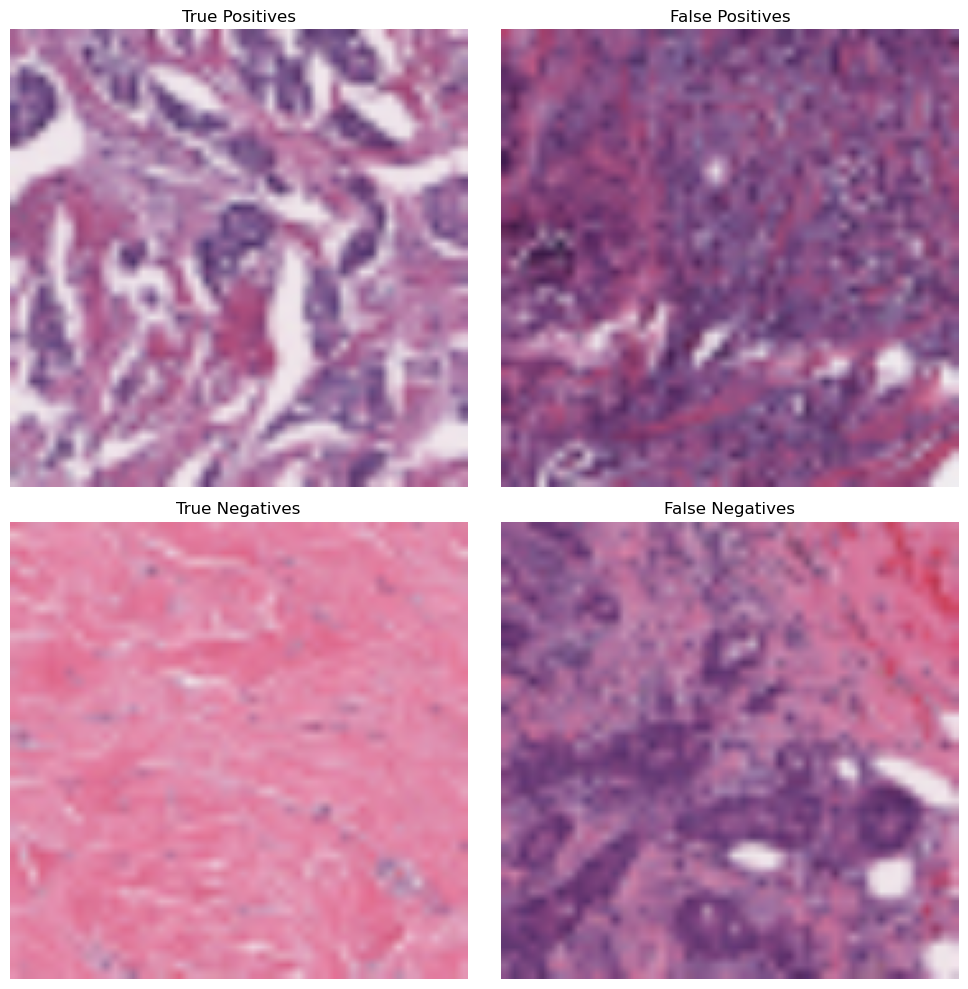

In [106]:
import matplotlib.pyplot as plt

# Define your TP_indices, FP_indices, TN_indices, FN_indices
# based on your classifier's predictions and true labels

# Create a figure with subplots
fig_cnn_sce, axes_cnn_sce = plt.subplots(2, 2, figsize=(10, 10))

# Loop through the test dataset to visualize images
for images_cnn_sce, labels_cnn_sce in test_ds.take(1):
    for i in range(images_cnn_sce.shape[0]):
        # Check if the image is a TP, FP, TN, or FN based on indices
        if i in TP_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[0, 0]
            title_cnn_sce = "True Positives"
        elif i in FP_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[0, 1]
            title_cnn_sce = "False Positives"
        elif i in TN_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[1, 0]
            title_cnn_sce = "True Negatives"
        elif i in FN_indices_cnn_sce:
            ax_cnn_sce = axes_cnn_sce[1, 1]
            title_cnn_sce = "False Negatives"
        
        # Display the image in the corresponding subplot
        ax_cnn_sce.imshow(images_cnn_sce[i].numpy())
        ax_cnn_sce.set_title(title_cnn_sce)
        ax_cnn_sce.axis("off")

plt.tight_layout()
plt.show()

### Testing the model

In [107]:
from PIL import Image
model_cnnscepath = "bc_modelCNNsce.h5"
load_cnnscemodel = tf.keras.models.load_model(model_cnnscepath)

# test_image = cv2.imread("/Users/opeoluwa/Downloads/dissertation_project/BreastHistopathologyImages/16896/0/16896_idx5_x101_y651_class0.png")
# test_image = cv2.imread("/Users/opeoluwa/Downloads/dissertation_project/BreastHistopathologyImages/16896/0/16896_idx5_x101_y951_class0.png")
test_image_cnn_sce = cv2.imread("/Users/opeoluwa/Downloads/dissertation_project/BreastHistopathologyImages/16896/1/16896_idx5_x201_y801_class1.png")
imagearray_cnn_sce = Image.fromarray(test_image_cnn_sce, 'RGB')
imageresize_cnn_sce = imagearray_cnn_sce.resize((img_height, img_width))
imageexpand_cnn_sce = np.expand_dims(imageresize_cnn_sce, axis=0)
test_input_cnn_sce = np.array(imageexpand_cnn_sce)
test_input_cnn_sce = test_input_cnn_sce/255


pred_cnn_sce = load_cnnscemodel.predict(test_input_cnn_sce)
# if pred_cnn_sce >=0.5:
#     print('malignant')
# else:
#     print('benign')
    

    
# Choose a threshold (e.g., 0.5)
threshold_cnn_sce = 0.5

# Use np.where to classify the samples
predictions_cnn_sce = np.where(pred_cnn_sce[0][0] >= threshold_cnn_sce, 'malignant', 'benign')

# Print the classification results
print(predictions_cnn_sce)



1/1 [==============================] - 0s 34ms/step
benign


# CNN SCE- STANDARD ERROR RATE

In [151]:
train_loss_cnn_sce = 0.2415

In [182]:
#VGG16 sparsecategoricalcrossentropy
cnnscetrain_num = (1 - train_loss_cnn_sce)
len_cnnscetrain_ds = len(train_ds)*batch_size
train1_error_csce = (train_loss_cnn_sce) - 1.96 * math.sqrt((train_loss_cnn_sce*cnnscetrain_num)/len_cnnscetrain_ds)
train2_error_csce = (train_loss_cnn_sce) + 1.96 * math.sqrt((train_loss_cnn_sce*cnnscetrain_num)/len_cnnscetrain_ds)

In [183]:
print(train1_error_csce)
print(train2_error_csce)

0.22235101688757872
0.23871767293557192


In [184]:
print(f'{train1_error_csce:.4f} - {train2_error_csce:.4f}')

0.2224 - 0.2387


In [154]:
val_loss_cnn_sce_loss = 0.2474

In [171]:
cnnsceval_num = (1-val_loss_cnn_sce)
len_cnnsceval_ds = len(val_ds)*batch_size
val1_error_csce = (val_loss_cnn_sce) - 1.96 * math.sqrt(val_loss_cnn_sce*(cnnsceval_num/len_cnnsceval_ds))
val2_error_csce = (val_loss_cnn_sce) + 1.96 * math.sqrt(val_loss_cnn_sce*(cnnsceval_num/len_cnnsceval_ds))

print(f'{val1_error_csce:.4f} - {val2_error_csce:.4f}')

0.2275 - 0.2608


In [156]:
test_loss_cnn_sce_loss = 0.2627

In [172]:
cnnscetest_num = (1-test_loss_cnn_sce)
len_cnnscetest_ds = len(test_ds)*batch_size
test1_error_csce = (test_loss_cnn_sce) - 1.96 * math.sqrt(test_loss_cnn_sce*(cnnscetest_num/len_cnnscetest_ds))
test2_error_csce = (test_loss_cnn_sce) + 1.96 * math.sqrt(test_loss_cnn_sce*(cnnscetest_num/len_cnnscetest_ds))

print(f'{test1_error_csce:.4f} - {test2_error_csce:.4f}')

0.2239 - 0.2718
